In [ ]:
from keras.models import load_model,Sequential
from keras.layers import Input, Dense, LSTM,Dropout
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datalist =  [f for f in glob.glob('drive/MyDrive/Dataset Selected/*.csv')]
len(datalist)

75

In [ ]:
def signal_to_catagorical(data):
    data.loc[data['Trend GT'] == 'up', 'Trend GT'] = 0
    data.loc[data['Trend GT'] == 'down', 'Trend GT'] = 1 
    return data

def shiftdata(df,col_name,sft):
    for i in range(sft):
        i+=1
        shiftname = col_name+'-'+str(i)
        df[shiftname] = df[col_name].shift(i)

    return df

def add_shift_day(data,day):
    r_list = []
    for i in range(day,len(data)):#Number mean day to shift
        r_list.append(data[i-day : i])
    return np.array(r_list)

def norm(df,col_name):# this will get columnname + _n
    #Normalize data each colunm in to range -1 to 1
    df[col_name+'_n'] = 2*(df[col_name]-df[col_name].min())/(df[col_name].max()-df[col_name].min())-1
    return df


In [ ]:
#train set
data = np.array([])
counter = False
print(len(datalist))
for stock in range(len(datalist)-10): 
    df = pd.read_csv(datalist[stock])
    df = signal_to_catagorical(df)
    df = df.dropna()
    train_feat = df[['MACD-SL_n','DMI_n','STOCH_n','RSI_n','%R_n']].values
    train_feat = add_shift_day(train_feat,30)
    if counter == False:
        x_train = train_feat
        counter = True
        y_train = df['Trend GT'][30:]
    else:
        x_train = np.concatenate([x_train,train_feat])
        y_train = pd.concat([y_train,df['Trend GT'][30:]])
y_train = to_categorical(y_train)

print(x_train.shape)
print(y_train.shape)

75
(171946, 30, 5)
(171946, 2)


In [ ]:
#validation set
counter = False
for val_name in range(65,71):
    df = pd.read_csv(datalist[val_name])
    df = signal_to_catagorical(df)
    df = df.dropna()
    val_feat = df[['MACD-SL_n','DMI_n','STOCH_n','RSI_n','%R_n']].values
    val_feat = add_shift_day(val_feat,30)
    if counter == False:
        x_val = val_feat
        counter = True
        y_val = df['Trend GT'][30:]

    else:
        x_val = np.concatenate([x_val,val_feat])
        y_val = pd.concat([y_val,df['Trend GT'][30:]])
y_val = to_categorical(y_val)
  
print(x_val.shape)
print(y_val.shape)

(15096, 30, 5)
(15096, 2)


In [ ]:
#Create LSTM model
model = Sequential()
model.add(LSTM(20, input_shape=((30,5)),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 20)            2080      
_________________________________________________________________
dropout (Dropout)            (None, 30, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 3,342
Trainable params: 3,342
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model = load_model('drive/MyDrive/Dataset/model/model_LSTM_notrading.h5')

In [ ]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_acc'))

        plt.clf()
        plt.plot(self.x, self.losses, label='acc')
        plt.plot(self.x, self.val_losses, label='val_acc')
        plt.legend()
        plt.pause(0.01)

checkpoint = ModelCheckpoint('drive/MyDrive/Dataset/model/model_LSTM_selected_checkpoint1.h5',
                               verbose=1,
                               monitor='val_acc',
                               mode='max',
                               save_best_only = True)
plot_losses = PlotLosses()

In [ ]:
# model = load_model('drive/MyDrive/Dataset/model/model_LSTM_noga_500ep.h5')

Epoch 1/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4947 - acc: 0.7537 - val_loss: 0.7523 - val_acc: 0.6316

Epoch 00001: val_acc did not improve from 0.67256


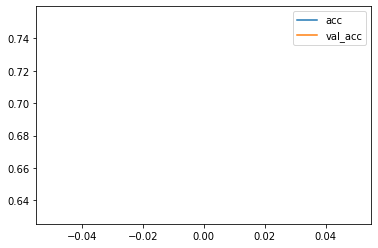

Epoch 2/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4945 - acc: 0.7543 - val_loss: 0.8084 - val_acc: 0.6180

Epoch 00002: val_acc did not improve from 0.67256


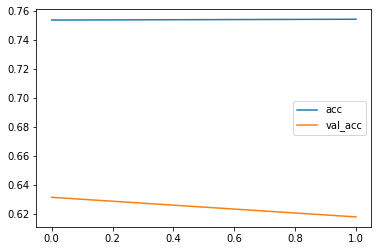

Epoch 3/100
5374/5374 [==============================] - 32s 6ms/step - loss: 0.4926 - acc: 0.7552 - val_loss: 0.7919 - val_acc: 0.6235

Epoch 00003: val_acc did not improve from 0.67256


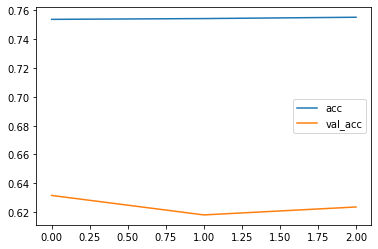

Epoch 4/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4937 - acc: 0.7537 - val_loss: 0.7539 - val_acc: 0.6273

Epoch 00004: val_acc did not improve from 0.67256


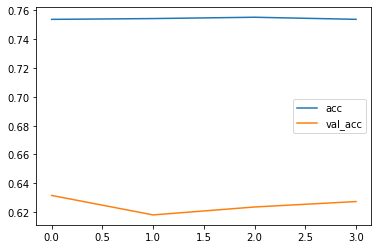

Epoch 5/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4919 - acc: 0.7558 - val_loss: 0.7813 - val_acc: 0.6239

Epoch 00005: val_acc did not improve from 0.67256


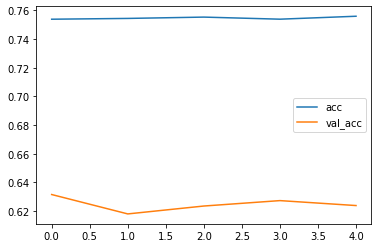

Epoch 6/100
5374/5374 [==============================] - 32s 6ms/step - loss: 0.4920 - acc: 0.7554 - val_loss: 0.7735 - val_acc: 0.6279

Epoch 00006: val_acc did not improve from 0.67256


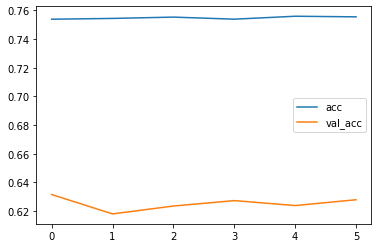

Epoch 7/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4922 - acc: 0.7552 - val_loss: 0.7807 - val_acc: 0.6194

Epoch 00007: val_acc did not improve from 0.67256


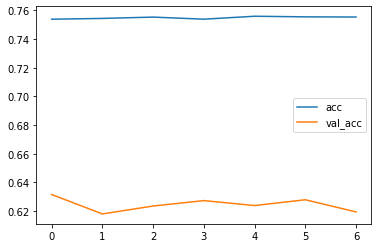

Epoch 8/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4907 - acc: 0.7558 - val_loss: 0.7835 - val_acc: 0.6253

Epoch 00008: val_acc did not improve from 0.67256


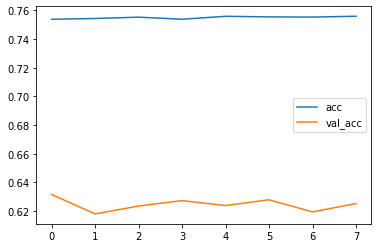

Epoch 9/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4916 - acc: 0.7566 - val_loss: 0.7877 - val_acc: 0.6173

Epoch 00009: val_acc did not improve from 0.67256


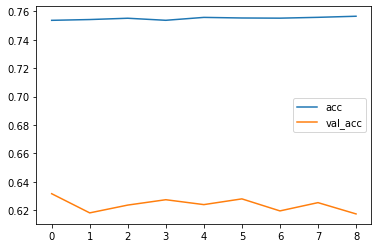

Epoch 10/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4899 - acc: 0.7577 - val_loss: 0.8071 - val_acc: 0.6148

Epoch 00010: val_acc did not improve from 0.67256


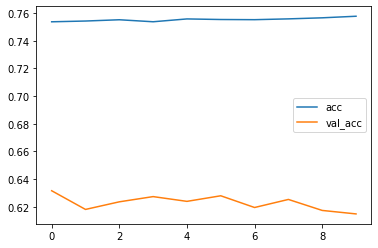

Epoch 11/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4900 - acc: 0.7572 - val_loss: 0.7836 - val_acc: 0.6254

Epoch 00011: val_acc did not improve from 0.67256


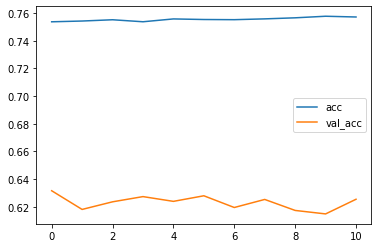

Epoch 12/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4904 - acc: 0.7563 - val_loss: 0.7860 - val_acc: 0.6235

Epoch 00012: val_acc did not improve from 0.67256


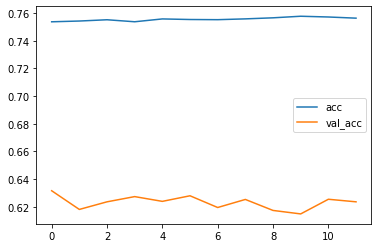

Epoch 13/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4897 - acc: 0.7578 - val_loss: 0.7898 - val_acc: 0.6192

Epoch 00013: val_acc did not improve from 0.67256


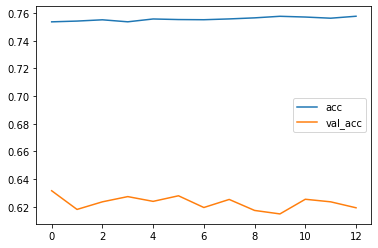

Epoch 14/100
5374/5374 [==============================] - 35s 6ms/step - loss: 0.4897 - acc: 0.7576 - val_loss: 0.8065 - val_acc: 0.6179

Epoch 00014: val_acc did not improve from 0.67256


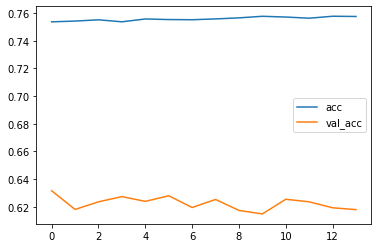

Epoch 15/100
5374/5374 [==============================] - 35s 7ms/step - loss: 0.4883 - acc: 0.7587 - val_loss: 0.7835 - val_acc: 0.6220

Epoch 00015: val_acc did not improve from 0.67256


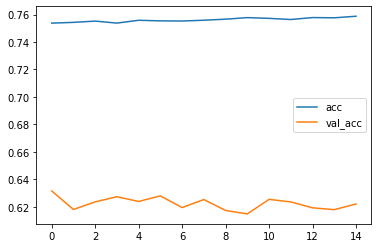

Epoch 16/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4881 - acc: 0.7563 - val_loss: 0.7981 - val_acc: 0.6285

Epoch 00016: val_acc did not improve from 0.67256


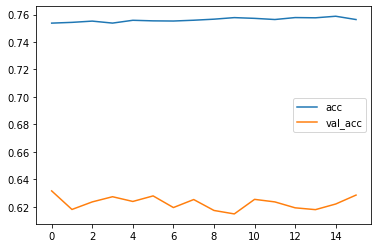

Epoch 17/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4895 - acc: 0.7579 - val_loss: 0.7839 - val_acc: 0.6219

Epoch 00017: val_acc did not improve from 0.67256


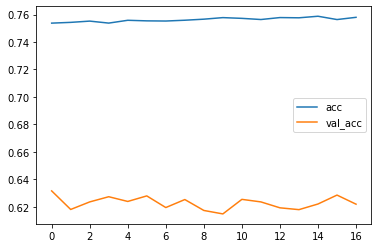

Epoch 18/100
5374/5374 [==============================] - 33s 6ms/step - loss: 0.4884 - acc: 0.7580 - val_loss: 0.7915 - val_acc: 0.6316

Epoch 00018: val_acc did not improve from 0.67256


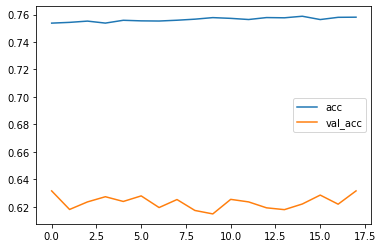

Epoch 19/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4882 - acc: 0.7588 - val_loss: 0.7849 - val_acc: 0.6186

Epoch 00019: val_acc did not improve from 0.67256


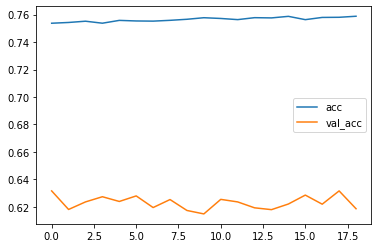

Epoch 20/100
5374/5374 [==============================] - 35s 6ms/step - loss: 0.4871 - acc: 0.7592 - val_loss: 0.7964 - val_acc: 0.6253

Epoch 00020: val_acc did not improve from 0.67256


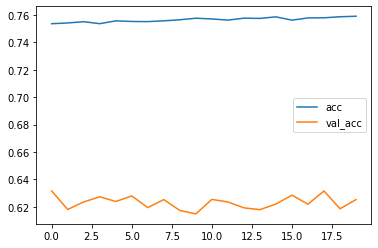

Epoch 21/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4881 - acc: 0.7586 - val_loss: 0.7994 - val_acc: 0.6111

Epoch 00021: val_acc did not improve from 0.67256


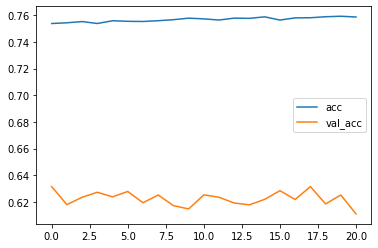

Epoch 22/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4869 - acc: 0.7590 - val_loss: 0.7890 - val_acc: 0.6309

Epoch 00022: val_acc did not improve from 0.67256


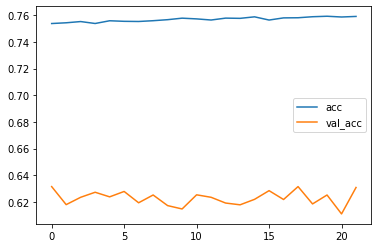

Epoch 23/100
5374/5374 [==============================] - 35s 6ms/step - loss: 0.4879 - acc: 0.7586 - val_loss: 0.7775 - val_acc: 0.6121

Epoch 00023: val_acc did not improve from 0.67256


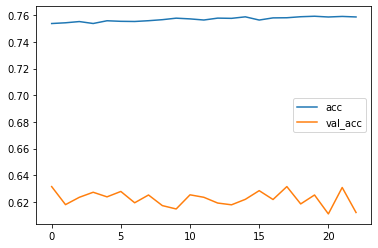

Epoch 24/100
5374/5374 [==============================] - 35s 6ms/step - loss: 0.4875 - acc: 0.7587 - val_loss: 0.7821 - val_acc: 0.6259

Epoch 00024: val_acc did not improve from 0.67256


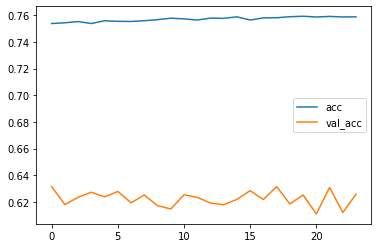

Epoch 25/100
5374/5374 [==============================] - 35s 6ms/step - loss: 0.4875 - acc: 0.7587 - val_loss: 0.8108 - val_acc: 0.6098

Epoch 00025: val_acc did not improve from 0.67256


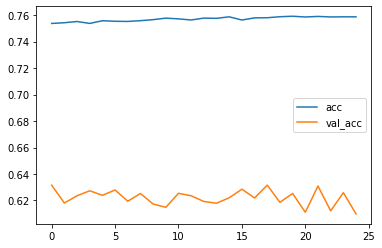

Epoch 26/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4872 - acc: 0.7598 - val_loss: 0.8080 - val_acc: 0.6214

Epoch 00026: val_acc did not improve from 0.67256


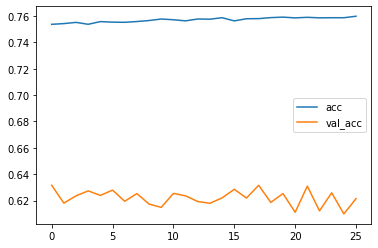

Epoch 27/100
5374/5374 [==============================] - 35s 7ms/step - loss: 0.4875 - acc: 0.7593 - val_loss: 0.7856 - val_acc: 0.6203

Epoch 00027: val_acc did not improve from 0.67256


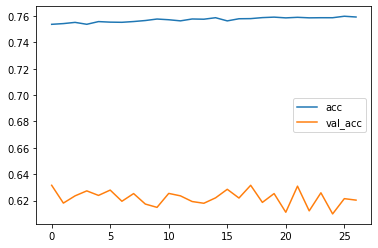

Epoch 28/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4868 - acc: 0.7588 - val_loss: 0.7653 - val_acc: 0.6327

Epoch 00028: val_acc did not improve from 0.67256


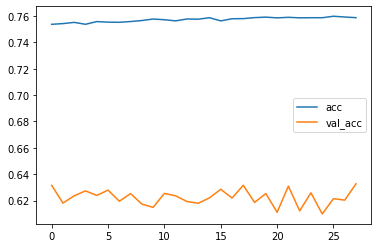

Epoch 29/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4857 - acc: 0.7594 - val_loss: 0.7926 - val_acc: 0.6196

Epoch 00029: val_acc did not improve from 0.67256


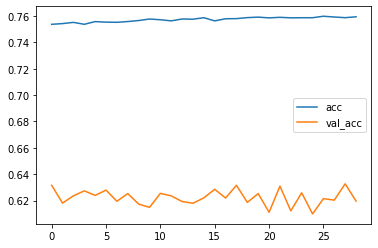

Epoch 30/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4852 - acc: 0.7598 - val_loss: 0.7870 - val_acc: 0.6243

Epoch 00030: val_acc did not improve from 0.67256


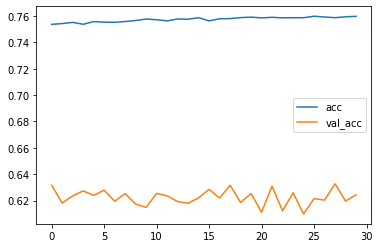

Epoch 31/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4842 - acc: 0.7610 - val_loss: 0.7582 - val_acc: 0.6307

Epoch 00031: val_acc did not improve from 0.67256


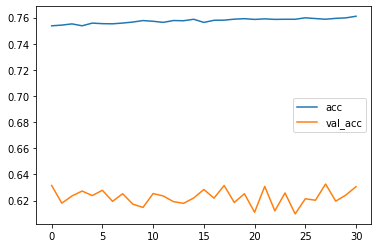

Epoch 32/100
5374/5374 [==============================] - 34s 6ms/step - loss: 0.4860 - acc: 0.7603 - val_loss: 0.7810 - val_acc: 0.6229

Epoch 00032: val_acc did not improve from 0.67256


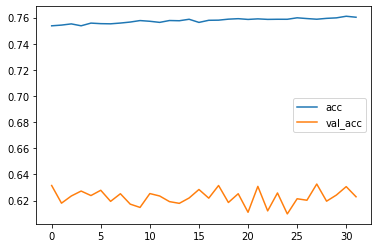

Epoch 33/100
5374/5374 [==============================] - 35s 7ms/step - loss: 0.4842 - acc: 0.7615 - val_loss: 0.8081 - val_acc: 0.6120

Epoch 00033: val_acc did not improve from 0.67256


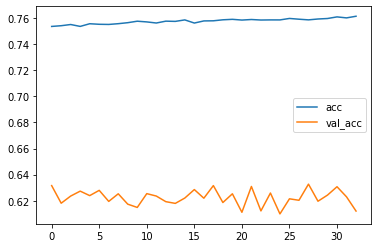

Epoch 34/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4859 - acc: 0.7595 - val_loss: 0.7987 - val_acc: 0.6305

Epoch 00034: val_acc did not improve from 0.67256


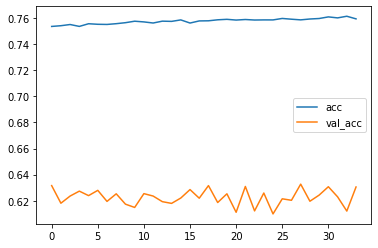

Epoch 35/100
5374/5374 [==============================] - 35s 7ms/step - loss: 0.4841 - acc: 0.7610 - val_loss: 0.7981 - val_acc: 0.6186

Epoch 00035: val_acc did not improve from 0.67256


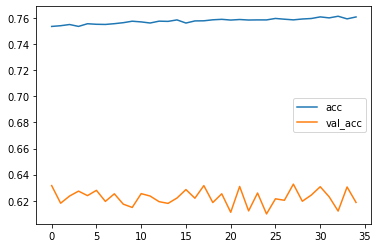

Epoch 36/100
5374/5374 [==============================] - 35s 7ms/step - loss: 0.4846 - acc: 0.7598 - val_loss: 0.7958 - val_acc: 0.6250

Epoch 00036: val_acc did not improve from 0.67256


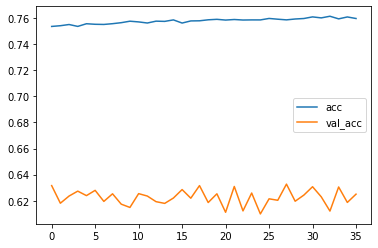

Epoch 37/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4837 - acc: 0.7616 - val_loss: 0.7892 - val_acc: 0.6286

Epoch 00037: val_acc did not improve from 0.67256


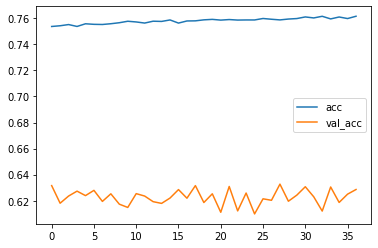

Epoch 38/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4830 - acc: 0.7623 - val_loss: 0.8101 - val_acc: 0.6184

Epoch 00038: val_acc did not improve from 0.67256


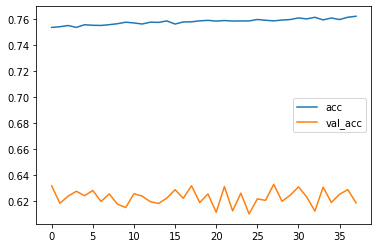

Epoch 39/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4833 - acc: 0.7617 - val_loss: 0.8005 - val_acc: 0.6296

Epoch 00039: val_acc did not improve from 0.67256


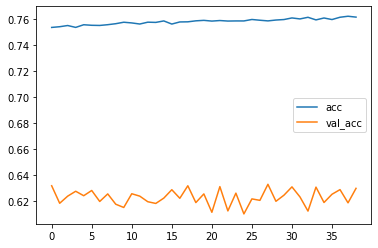

Epoch 40/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4836 - acc: 0.7607 - val_loss: 0.8103 - val_acc: 0.6171

Epoch 00040: val_acc did not improve from 0.67256


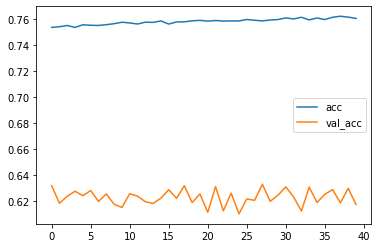

Epoch 41/100
5374/5374 [==============================] - 36s 7ms/step - loss: 0.4829 - acc: 0.7624 - val_loss: 0.8144 - val_acc: 0.6172

Epoch 00041: val_acc did not improve from 0.67256


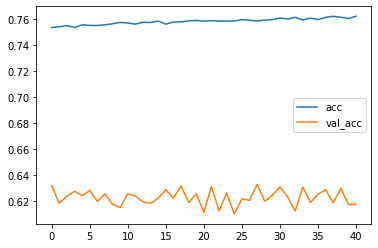

Epoch 42/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4834 - acc: 0.7613 - val_loss: 0.8103 - val_acc: 0.6153

Epoch 00042: val_acc did not improve from 0.67256


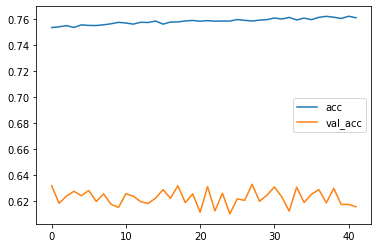

Epoch 43/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4820 - acc: 0.7630 - val_loss: 0.8408 - val_acc: 0.6031

Epoch 00043: val_acc did not improve from 0.67256


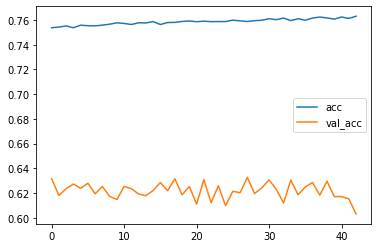

Epoch 44/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4823 - acc: 0.7616 - val_loss: 0.8278 - val_acc: 0.6224

Epoch 00044: val_acc did not improve from 0.67256


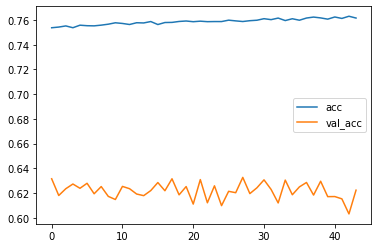

Epoch 45/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4834 - acc: 0.7614 - val_loss: 0.8075 - val_acc: 0.6094

Epoch 00045: val_acc did not improve from 0.67256


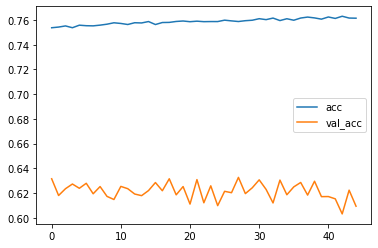

Epoch 46/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4825 - acc: 0.7618 - val_loss: 0.8065 - val_acc: 0.6176

Epoch 00046: val_acc did not improve from 0.67256


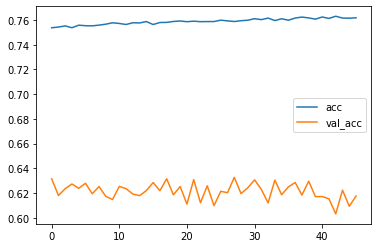

Epoch 47/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4823 - acc: 0.7606 - val_loss: 0.8048 - val_acc: 0.6177

Epoch 00047: val_acc did not improve from 0.67256


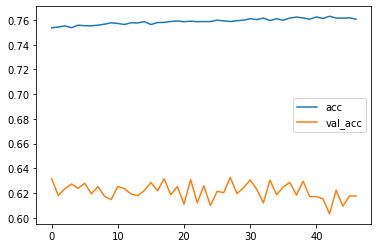

Epoch 48/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4821 - acc: 0.7619 - val_loss: 0.8042 - val_acc: 0.6151

Epoch 00048: val_acc did not improve from 0.67256


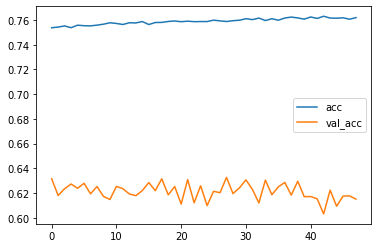

Epoch 49/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4819 - acc: 0.7623 - val_loss: 0.8268 - val_acc: 0.6151

Epoch 00049: val_acc did not improve from 0.67256


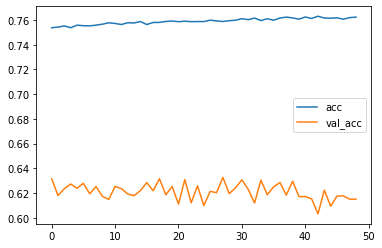

Epoch 50/100
5374/5374 [==============================] - 38s 7ms/step - loss: 0.4814 - acc: 0.7623 - val_loss: 0.8037 - val_acc: 0.6200

Epoch 00050: val_acc did not improve from 0.67256


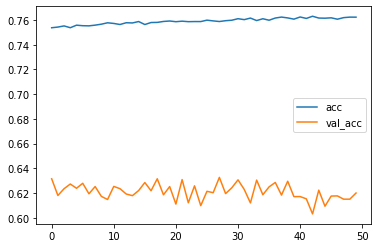

Epoch 51/100
5374/5374 [==============================] - 38s 7ms/step - loss: 0.4817 - acc: 0.7618 - val_loss: 0.8119 - val_acc: 0.6076

Epoch 00051: val_acc did not improve from 0.67256


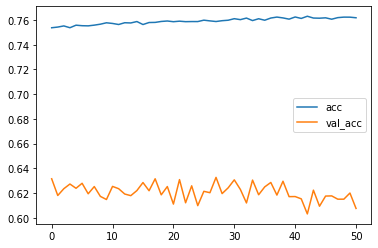

Epoch 52/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4810 - acc: 0.7624 - val_loss: 0.8027 - val_acc: 0.6121

Epoch 00052: val_acc did not improve from 0.67256


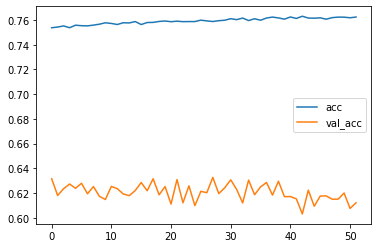

Epoch 53/100
5374/5374 [==============================] - 38s 7ms/step - loss: 0.4800 - acc: 0.7642 - val_loss: 0.8182 - val_acc: 0.6134

Epoch 00053: val_acc did not improve from 0.67256


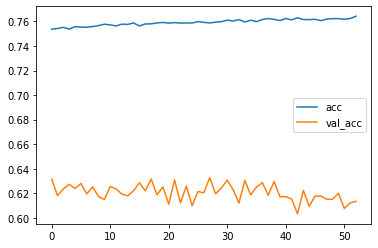

Epoch 54/100
5374/5374 [==============================] - 37s 7ms/step - loss: 0.4814 - acc: 0.7636 - val_loss: 0.8046 - val_acc: 0.6102

Epoch 00054: val_acc did not improve from 0.67256


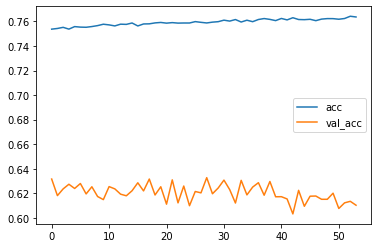

Epoch 55/100
5374/5374 [==============================] - 38s 7ms/step - loss: 0.4799 - acc: 0.7630 - val_loss: 0.8136 - val_acc: 0.6180

Epoch 00055: val_acc did not improve from 0.67256


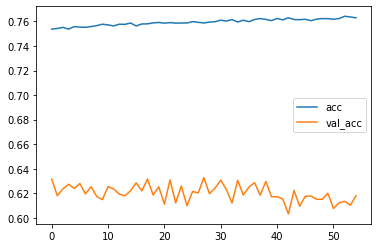

Epoch 56/100
5374/5374 [==============================] - 39s 7ms/step - loss: 0.4810 - acc: 0.7634 - val_loss: 0.8113 - val_acc: 0.6098

Epoch 00056: val_acc did not improve from 0.67256


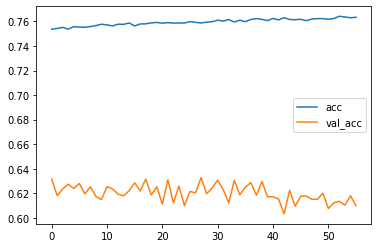

Epoch 57/100
5374/5374 [==============================] - 39s 7ms/step - loss: 0.4799 - acc: 0.7633 - val_loss: 0.8135 - val_acc: 0.6114

Epoch 00057: val_acc did not improve from 0.67256


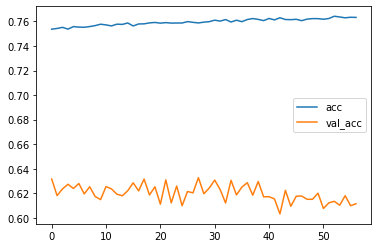

Epoch 58/100
5374/5374 [==============================] - 39s 7ms/step - loss: 0.4812 - acc: 0.7638 - val_loss: 0.8245 - val_acc: 0.6108

Epoch 00058: val_acc did not improve from 0.67256


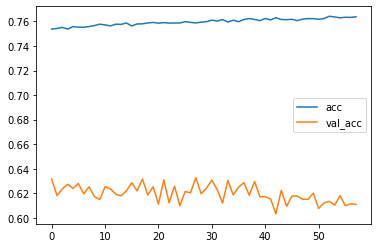

Epoch 59/100
5374/5374 [==============================] - 39s 7ms/step - loss: 0.4818 - acc: 0.7629 - val_loss: 0.7970 - val_acc: 0.6205

Epoch 00059: val_acc did not improve from 0.67256


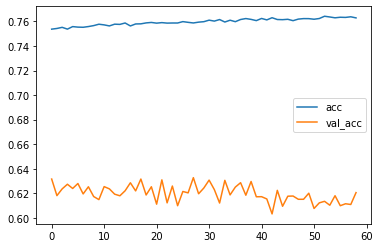

Epoch 60/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4810 - acc: 0.7638 - val_loss: 0.7889 - val_acc: 0.6258

Epoch 00060: val_acc did not improve from 0.67256


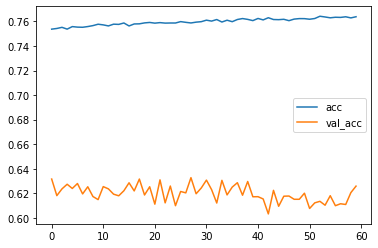

Epoch 61/100
5374/5374 [==============================] - 39s 7ms/step - loss: 0.4792 - acc: 0.7643 - val_loss: 0.7912 - val_acc: 0.6258

Epoch 00061: val_acc did not improve from 0.67256


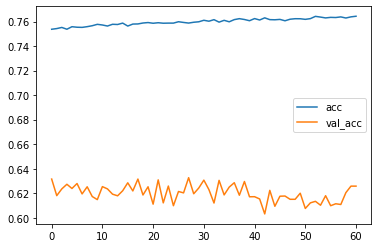

Epoch 62/100
5374/5374 [==============================] - 39s 7ms/step - loss: 0.4796 - acc: 0.7636 - val_loss: 0.8101 - val_acc: 0.6163

Epoch 00062: val_acc did not improve from 0.67256


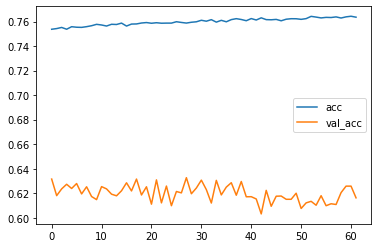

Epoch 63/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4788 - acc: 0.7635 - val_loss: 0.8209 - val_acc: 0.6161

Epoch 00063: val_acc did not improve from 0.67256


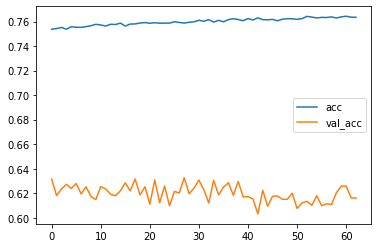

Epoch 64/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4794 - acc: 0.7646 - val_loss: 0.8136 - val_acc: 0.6201

Epoch 00064: val_acc did not improve from 0.67256


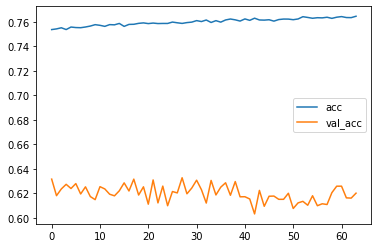

Epoch 65/100
5374/5374 [==============================] - 39s 7ms/step - loss: 0.4787 - acc: 0.7644 - val_loss: 0.8166 - val_acc: 0.6170

Epoch 00065: val_acc did not improve from 0.67256


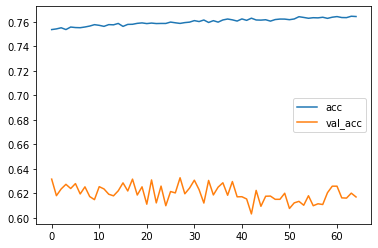

Epoch 66/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4782 - acc: 0.7645 - val_loss: 0.8114 - val_acc: 0.6186

Epoch 00066: val_acc did not improve from 0.67256


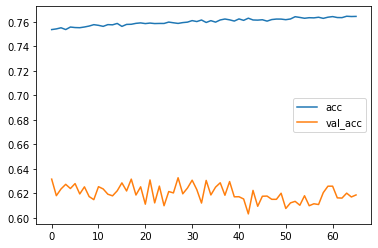

Epoch 67/100
5374/5374 [==============================] - 40s 8ms/step - loss: 0.4779 - acc: 0.7658 - val_loss: 0.8192 - val_acc: 0.6181

Epoch 00067: val_acc did not improve from 0.67256


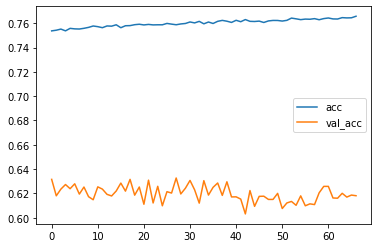

Epoch 68/100
5374/5374 [==============================] - 39s 7ms/step - loss: 0.4790 - acc: 0.7646 - val_loss: 0.8100 - val_acc: 0.6256

Epoch 00068: val_acc did not improve from 0.67256


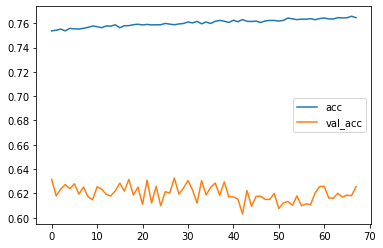

Epoch 69/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4776 - acc: 0.7656 - val_loss: 0.8274 - val_acc: 0.6135

Epoch 00069: val_acc did not improve from 0.67256


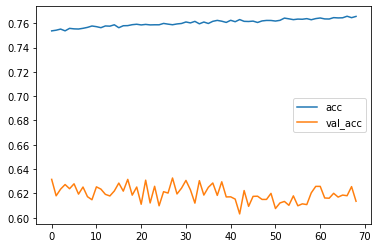

Epoch 70/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4772 - acc: 0.7658 - val_loss: 0.8177 - val_acc: 0.5998

Epoch 00070: val_acc did not improve from 0.67256


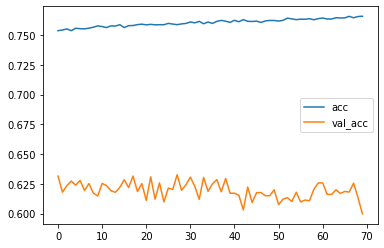

Epoch 71/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4768 - acc: 0.7665 - val_loss: 0.8359 - val_acc: 0.5982

Epoch 00071: val_acc did not improve from 0.67256


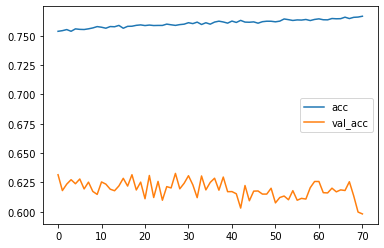

Epoch 72/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4782 - acc: 0.7656 - val_loss: 0.8268 - val_acc: 0.6125

Epoch 00072: val_acc did not improve from 0.67256


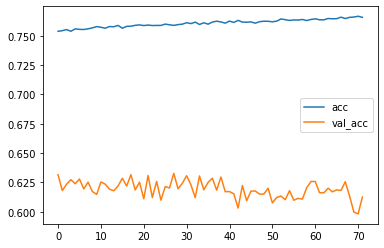

Epoch 73/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4768 - acc: 0.7661 - val_loss: 0.8002 - val_acc: 0.6207

Epoch 00073: val_acc did not improve from 0.67256


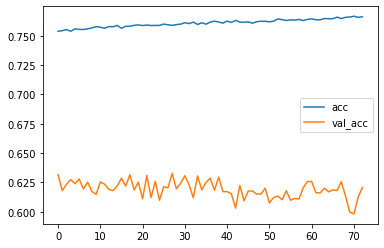

Epoch 74/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4777 - acc: 0.7654 - val_loss: 0.8371 - val_acc: 0.6108

Epoch 00074: val_acc did not improve from 0.67256


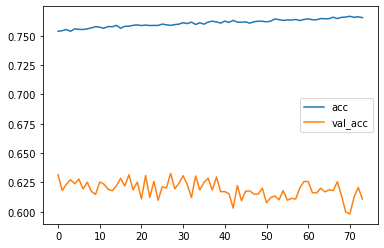

Epoch 75/100
5374/5374 [==============================] - 40s 8ms/step - loss: 0.4779 - acc: 0.7639 - val_loss: 0.7912 - val_acc: 0.6169

Epoch 00075: val_acc did not improve from 0.67256


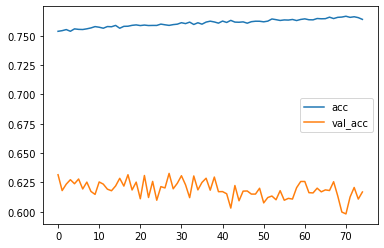

Epoch 76/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4757 - acc: 0.7664 - val_loss: 0.8106 - val_acc: 0.6190

Epoch 00076: val_acc did not improve from 0.67256


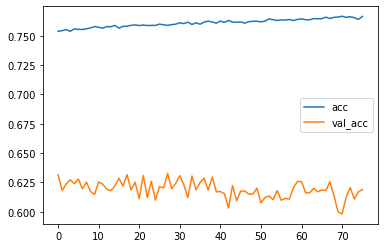

Epoch 77/100
5374/5374 [==============================] - 42s 8ms/step - loss: 0.4758 - acc: 0.7664 - val_loss: 0.8315 - val_acc: 0.6143

Epoch 00077: val_acc did not improve from 0.67256


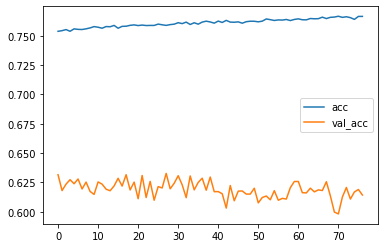

Epoch 78/100
5374/5374 [==============================] - 42s 8ms/step - loss: 0.4764 - acc: 0.7667 - val_loss: 0.8431 - val_acc: 0.6233

Epoch 00078: val_acc did not improve from 0.67256


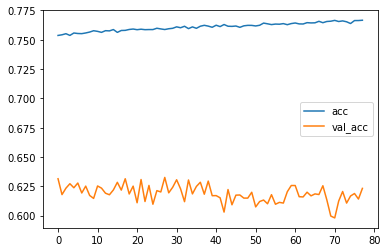

Epoch 79/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4753 - acc: 0.7667 - val_loss: 0.8268 - val_acc: 0.6090

Epoch 00079: val_acc did not improve from 0.67256


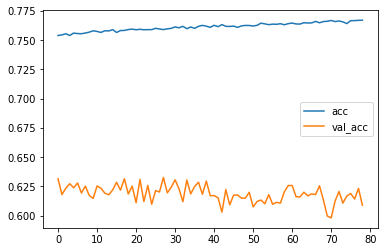

Epoch 80/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4756 - acc: 0.7677 - val_loss: 0.8104 - val_acc: 0.6160

Epoch 00080: val_acc did not improve from 0.67256


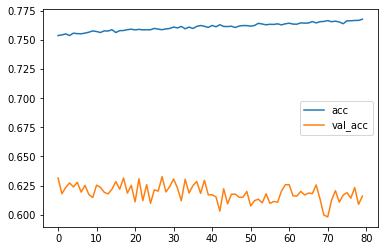

Epoch 81/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4759 - acc: 0.7674 - val_loss: 0.8442 - val_acc: 0.6129

Epoch 00081: val_acc did not improve from 0.67256


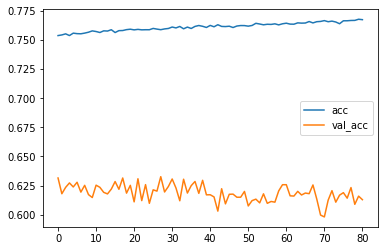

Epoch 82/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4764 - acc: 0.7662 - val_loss: 0.8241 - val_acc: 0.6157

Epoch 00082: val_acc did not improve from 0.67256


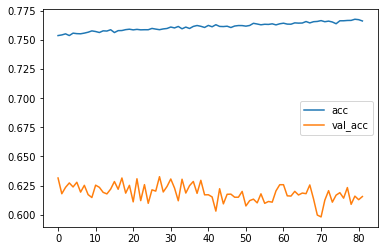

Epoch 83/100
5374/5374 [==============================] - 40s 7ms/step - loss: 0.4754 - acc: 0.7664 - val_loss: 0.8248 - val_acc: 0.6220

Epoch 00083: val_acc did not improve from 0.67256


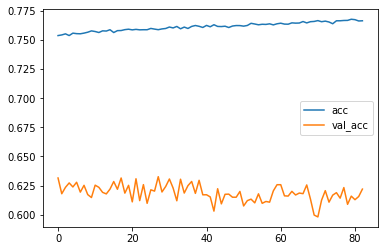

Epoch 84/100
5374/5374 [==============================] - 42s 8ms/step - loss: 0.4754 - acc: 0.7664 - val_loss: 0.8414 - val_acc: 0.6084

Epoch 00084: val_acc did not improve from 0.67256


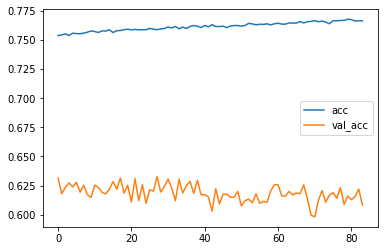

Epoch 85/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4767 - acc: 0.7673 - val_loss: 0.8099 - val_acc: 0.6182

Epoch 00085: val_acc did not improve from 0.67256


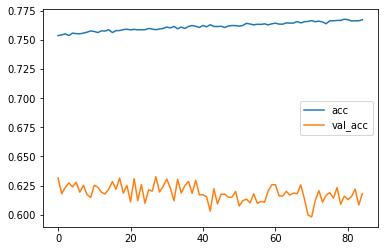

Epoch 86/100
5374/5374 [==============================] - 40s 8ms/step - loss: 0.4751 - acc: 0.7670 - val_loss: 0.8460 - val_acc: 0.6176

Epoch 00086: val_acc did not improve from 0.67256


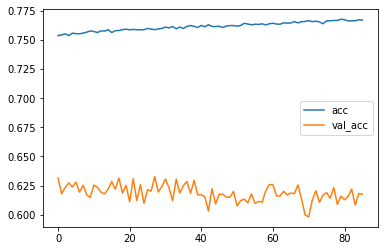

Epoch 87/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4754 - acc: 0.7674 - val_loss: 0.7933 - val_acc: 0.6263

Epoch 00087: val_acc did not improve from 0.67256


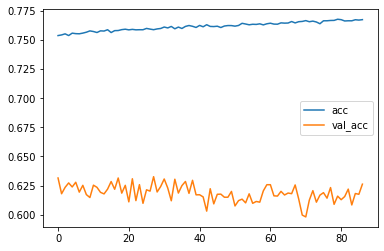

Epoch 88/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4747 - acc: 0.7675 - val_loss: 0.8245 - val_acc: 0.6104

Epoch 00088: val_acc did not improve from 0.67256


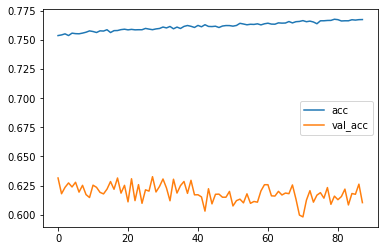

Epoch 89/100
5374/5374 [==============================] - 40s 8ms/step - loss: 0.4751 - acc: 0.7672 - val_loss: 0.8161 - val_acc: 0.6147

Epoch 00089: val_acc did not improve from 0.67256


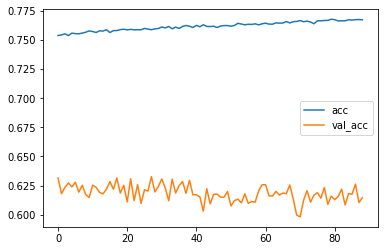

Epoch 90/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4750 - acc: 0.7676 - val_loss: 0.8236 - val_acc: 0.6178

Epoch 00090: val_acc did not improve from 0.67256


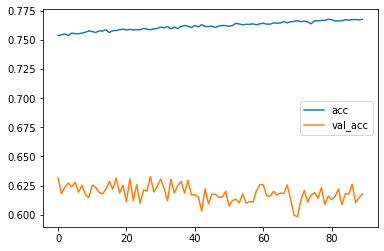

Epoch 91/100
5374/5374 [==============================] - 43s 8ms/step - loss: 0.4732 - acc: 0.7680 - val_loss: 0.8025 - val_acc: 0.6092

Epoch 00091: val_acc did not improve from 0.67256


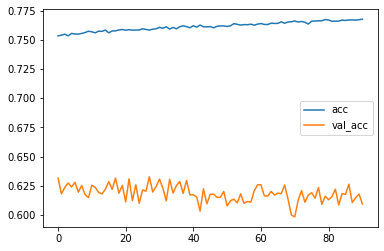

Epoch 92/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4762 - acc: 0.7669 - val_loss: 0.8176 - val_acc: 0.6232

Epoch 00092: val_acc did not improve from 0.67256


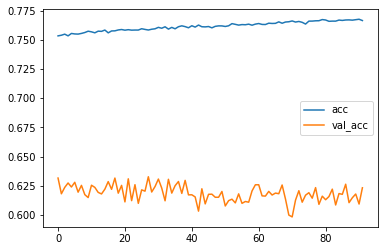

Epoch 93/100
5374/5374 [==============================] - 43s 8ms/step - loss: 0.4742 - acc: 0.7682 - val_loss: 0.8140 - val_acc: 0.6106

Epoch 00093: val_acc did not improve from 0.67256


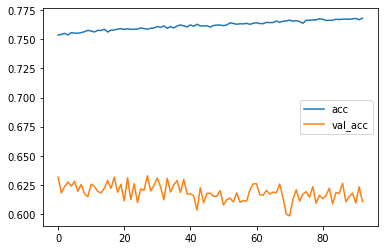

Epoch 94/100
5374/5374 [==============================] - 42s 8ms/step - loss: 0.4740 - acc: 0.7682 - val_loss: 0.8257 - val_acc: 0.6108

Epoch 00094: val_acc did not improve from 0.67256


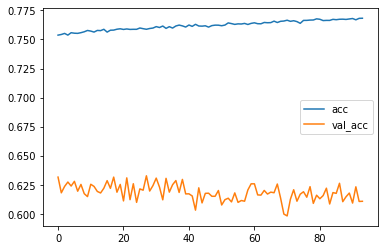

Epoch 95/100
5374/5374 [==============================] - 43s 8ms/step - loss: 0.4750 - acc: 0.7674 - val_loss: 0.7981 - val_acc: 0.6095

Epoch 00095: val_acc did not improve from 0.67256


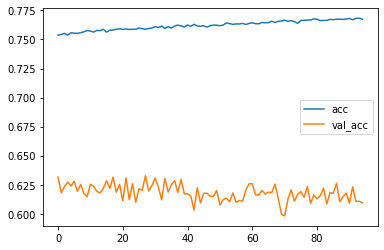

Epoch 96/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4749 - acc: 0.7669 - val_loss: 0.8104 - val_acc: 0.6202

Epoch 00096: val_acc did not improve from 0.67256


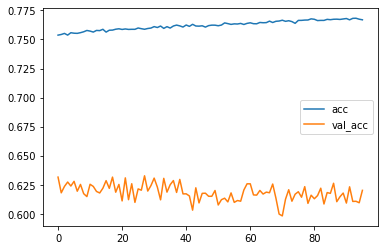

Epoch 97/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4736 - acc: 0.7681 - val_loss: 0.8190 - val_acc: 0.6165

Epoch 00097: val_acc did not improve from 0.67256


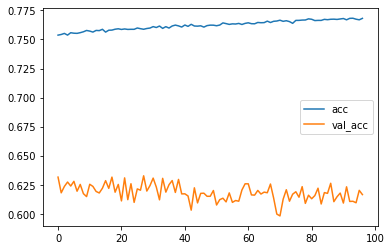

Epoch 98/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4729 - acc: 0.7690 - val_loss: 0.8363 - val_acc: 0.6053

Epoch 00098: val_acc did not improve from 0.67256


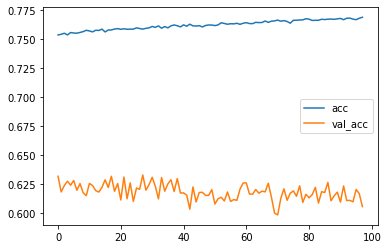

Epoch 99/100
5374/5374 [==============================] - 43s 8ms/step - loss: 0.4740 - acc: 0.7687 - val_loss: 0.8472 - val_acc: 0.5994

Epoch 00099: val_acc did not improve from 0.67256


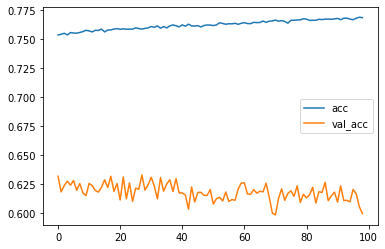

Epoch 100/100
5374/5374 [==============================] - 41s 8ms/step - loss: 0.4718 - acc: 0.7704 - val_loss: 0.8133 - val_acc: 0.6182

Epoch 00100: val_acc did not improve from 0.67256


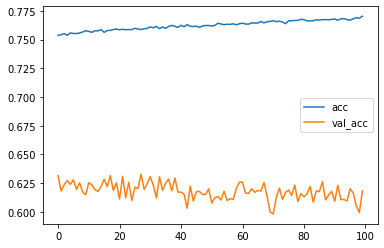

In [ ]:
#Train Model
h = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_val,y_val),
    callbacks=[checkpoint,plot_losses])
model.save('drive/MyDrive/model_LSTM_selected_200ep.h5')

Epoch 1/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4483 - acc: 0.7947 - val_loss: 0.7847 - val_acc: 0.6403

Epoch 00001: val_acc did not improve from 0.68460


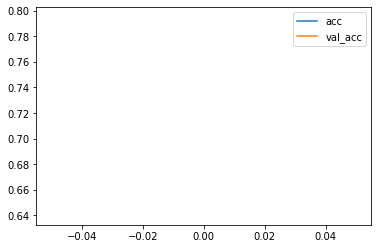

Epoch 2/100
5411/5411 [==============================] - 31s 6ms/step - loss: 0.4458 - acc: 0.7973 - val_loss: 0.7745 - val_acc: 0.6442

Epoch 00002: val_acc did not improve from 0.68460


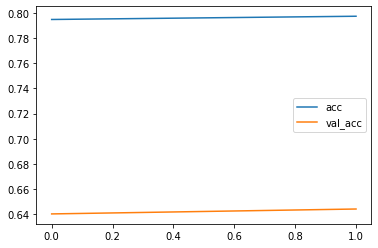

Epoch 3/100
5411/5411 [==============================] - 31s 6ms/step - loss: 0.4467 - acc: 0.7956 - val_loss: 0.8020 - val_acc: 0.6330

Epoch 00003: val_acc did not improve from 0.68460


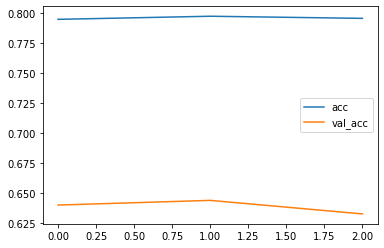

Epoch 4/100
5411/5411 [==============================] - 31s 6ms/step - loss: 0.4464 - acc: 0.7957 - val_loss: 0.7813 - val_acc: 0.6360

Epoch 00004: val_acc did not improve from 0.68460


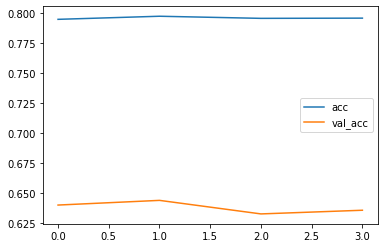

Epoch 5/100
5411/5411 [==============================] - 31s 6ms/step - loss: 0.4465 - acc: 0.7963 - val_loss: 0.7941 - val_acc: 0.6303

Epoch 00005: val_acc did not improve from 0.68460


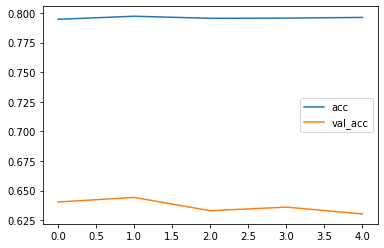

Epoch 6/100
5411/5411 [==============================] - 31s 6ms/step - loss: 0.4468 - acc: 0.7965 - val_loss: 0.7567 - val_acc: 0.6406

Epoch 00006: val_acc did not improve from 0.68460


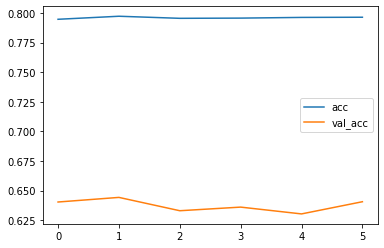

Epoch 7/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4473 - acc: 0.7953 - val_loss: 0.7687 - val_acc: 0.6430

Epoch 00007: val_acc did not improve from 0.68460


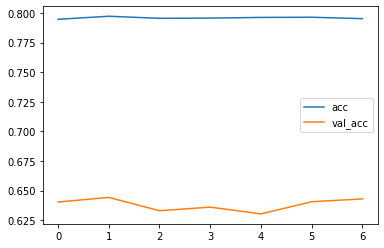

Epoch 8/100
5411/5411 [==============================] - 31s 6ms/step - loss: 0.4464 - acc: 0.7954 - val_loss: 0.7716 - val_acc: 0.6405

Epoch 00008: val_acc did not improve from 0.68460


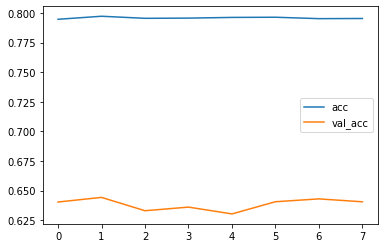

Epoch 9/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4463 - acc: 0.7967 - val_loss: 0.7952 - val_acc: 0.6340

Epoch 00009: val_acc did not improve from 0.68460


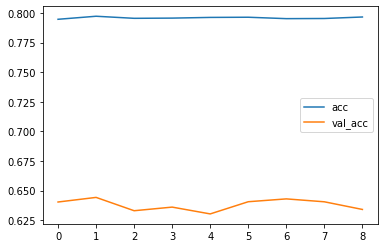

Epoch 10/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4473 - acc: 0.7952 - val_loss: 0.7731 - val_acc: 0.6423

Epoch 00010: val_acc did not improve from 0.68460


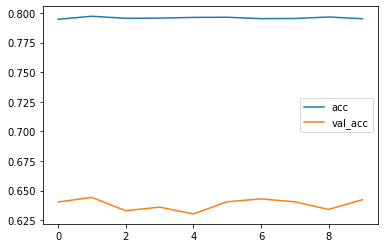

Epoch 11/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4467 - acc: 0.7957 - val_loss: 0.7715 - val_acc: 0.6452

Epoch 00011: val_acc did not improve from 0.68460


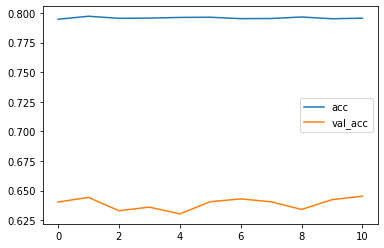

Epoch 12/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4469 - acc: 0.7959 - val_loss: 0.7505 - val_acc: 0.6396

Epoch 00012: val_acc did not improve from 0.68460


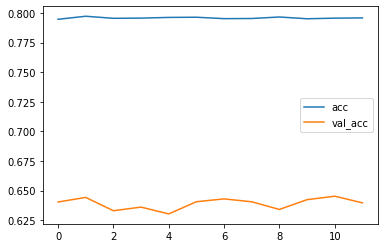

Epoch 13/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4463 - acc: 0.7959 - val_loss: 0.8110 - val_acc: 0.6336

Epoch 00013: val_acc did not improve from 0.68460


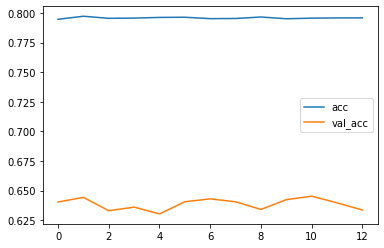

Epoch 14/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4459 - acc: 0.7963 - val_loss: 0.8009 - val_acc: 0.6316

Epoch 00014: val_acc did not improve from 0.68460


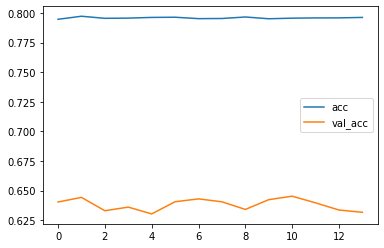

Epoch 15/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4470 - acc: 0.7957 - val_loss: 0.7716 - val_acc: 0.6431

Epoch 00015: val_acc did not improve from 0.68460


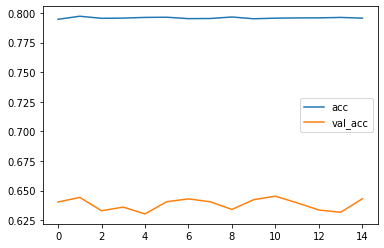

Epoch 16/100
5411/5411 [==============================] - 32s 6ms/step - loss: 0.4460 - acc: 0.7962 - val_loss: 0.7724 - val_acc: 0.6450

Epoch 00016: val_acc did not improve from 0.68460


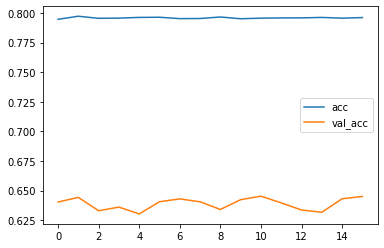

Epoch 17/100
5411/5411 [==============================] - 33s 6ms/step - loss: 0.4463 - acc: 0.7960 - val_loss: 0.7729 - val_acc: 0.6442

Epoch 00017: val_acc did not improve from 0.68460


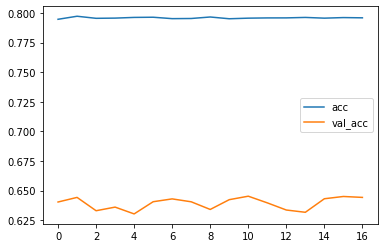

Epoch 18/100
5411/5411 [==============================] - 33s 6ms/step - loss: 0.4456 - acc: 0.7953 - val_loss: 0.7783 - val_acc: 0.6417

Epoch 00018: val_acc did not improve from 0.68460


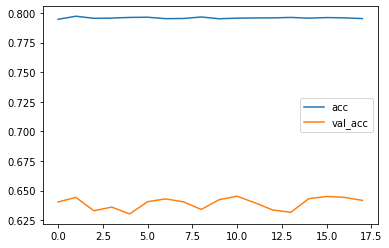

Epoch 19/100
5411/5411 [==============================] - 33s 6ms/step - loss: 0.4468 - acc: 0.7949 - val_loss: 0.7816 - val_acc: 0.6385

Epoch 00019: val_acc did not improve from 0.68460


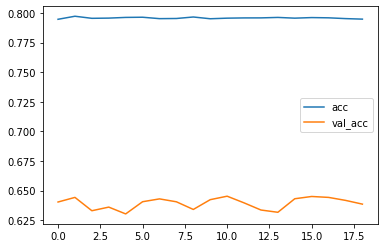

Epoch 20/100
5411/5411 [==============================] - 33s 6ms/step - loss: 0.4456 - acc: 0.7959 - val_loss: 0.7667 - val_acc: 0.6404

Epoch 00020: val_acc did not improve from 0.68460


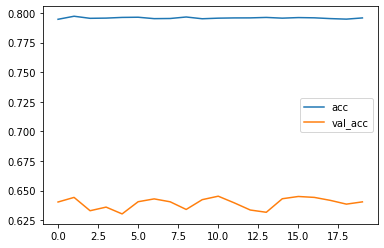

Epoch 21/100
5411/5411 [==============================] - 33s 6ms/step - loss: 0.4473 - acc: 0.7948 - val_loss: 0.7924 - val_acc: 0.6345

Epoch 00021: val_acc did not improve from 0.68460


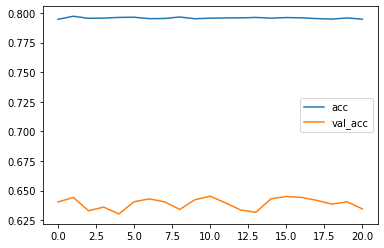

Epoch 22/100
5411/5411 [==============================] - 33s 6ms/step - loss: 0.4449 - acc: 0.7959 - val_loss: 0.7644 - val_acc: 0.6423

Epoch 00022: val_acc did not improve from 0.68460


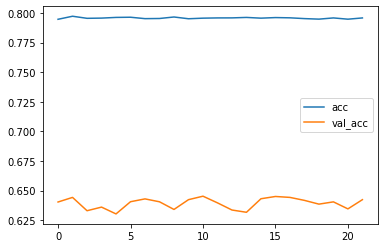

Epoch 23/100
5411/5411 [==============================] - 33s 6ms/step - loss: 0.4453 - acc: 0.7967 - val_loss: 0.8064 - val_acc: 0.6327

Epoch 00023: val_acc did not improve from 0.68460


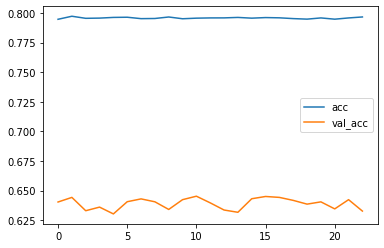

Epoch 24/100
5411/5411 [==============================] - 33s 6ms/step - loss: 0.4469 - acc: 0.7950 - val_loss: 0.7770 - val_acc: 0.6427

Epoch 00024: val_acc did not improve from 0.68460


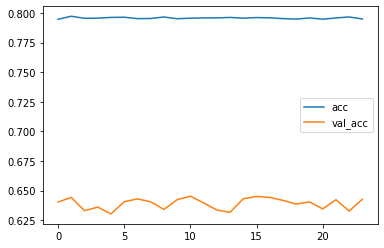

Epoch 25/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4459 - acc: 0.7965 - val_loss: 0.7708 - val_acc: 0.6443

Epoch 00025: val_acc did not improve from 0.68460


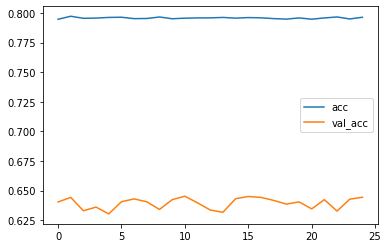

Epoch 26/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4465 - acc: 0.7958 - val_loss: 0.7900 - val_acc: 0.6434

Epoch 00026: val_acc did not improve from 0.68460


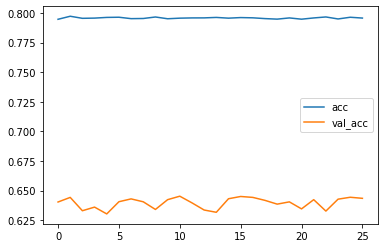

Epoch 27/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4466 - acc: 0.7955 - val_loss: 0.7707 - val_acc: 0.6444

Epoch 00027: val_acc did not improve from 0.68460


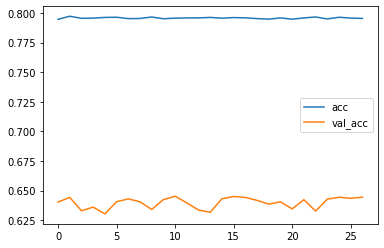

Epoch 28/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4458 - acc: 0.7962 - val_loss: 0.7735 - val_acc: 0.6382

Epoch 00028: val_acc did not improve from 0.68460


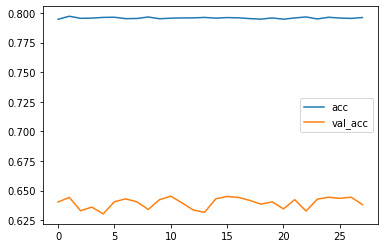

Epoch 29/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4450 - acc: 0.7962 - val_loss: 0.7957 - val_acc: 0.6366

Epoch 00029: val_acc did not improve from 0.68460


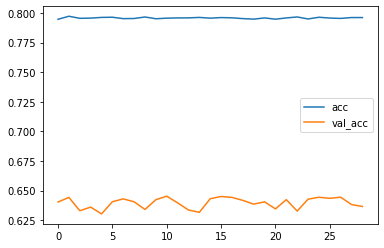

Epoch 30/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4454 - acc: 0.7963 - val_loss: 0.8184 - val_acc: 0.6335

Epoch 00030: val_acc did not improve from 0.68460


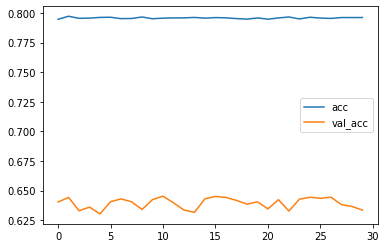

Epoch 31/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4432 - acc: 0.7971 - val_loss: 0.7935 - val_acc: 0.6376

Epoch 00031: val_acc did not improve from 0.68460


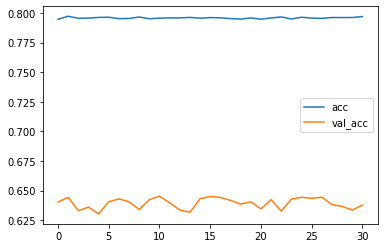

Epoch 32/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4459 - acc: 0.7963 - val_loss: 0.7860 - val_acc: 0.6324

Epoch 00032: val_acc did not improve from 0.68460


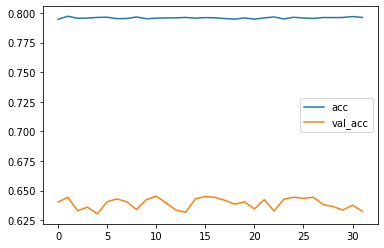

Epoch 33/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4451 - acc: 0.7971 - val_loss: 0.7942 - val_acc: 0.6394

Epoch 00033: val_acc did not improve from 0.68460


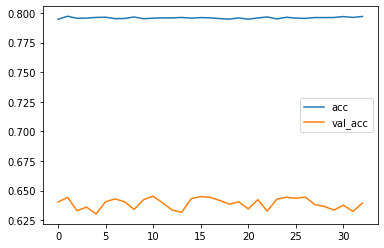

Epoch 34/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4453 - acc: 0.7961 - val_loss: 0.8024 - val_acc: 0.6400

Epoch 00034: val_acc did not improve from 0.68460


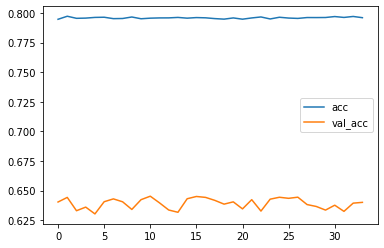

Epoch 35/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4460 - acc: 0.7970 - val_loss: 0.7876 - val_acc: 0.6315

Epoch 00035: val_acc did not improve from 0.68460


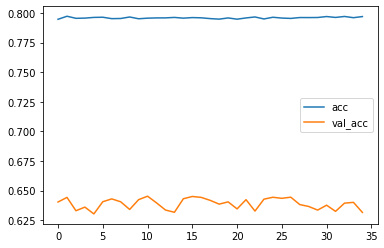

Epoch 36/100
5411/5411 [==============================] - 34s 6ms/step - loss: 0.4438 - acc: 0.7975 - val_loss: 0.7894 - val_acc: 0.6354

Epoch 00036: val_acc did not improve from 0.68460


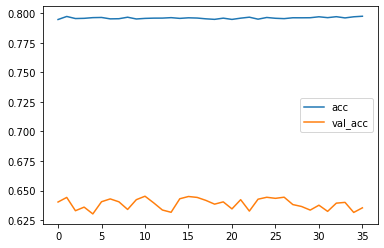

Epoch 37/100
5411/5411 [==============================] - 35s 6ms/step - loss: 0.4457 - acc: 0.7968 - val_loss: 0.8175 - val_acc: 0.6288

Epoch 00037: val_acc did not improve from 0.68460


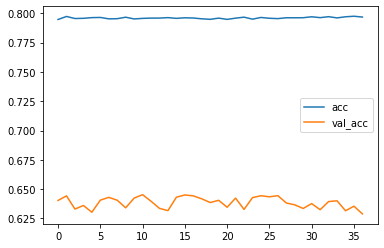

Epoch 38/100
5411/5411 [==============================] - 35s 6ms/step - loss: 0.4444 - acc: 0.7967 - val_loss: 0.7880 - val_acc: 0.6363

Epoch 00038: val_acc did not improve from 0.68460


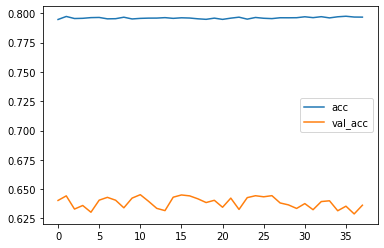

Epoch 39/100
5411/5411 [==============================] - 35s 6ms/step - loss: 0.4462 - acc: 0.7960 - val_loss: 0.8031 - val_acc: 0.6376

Epoch 00039: val_acc did not improve from 0.68460


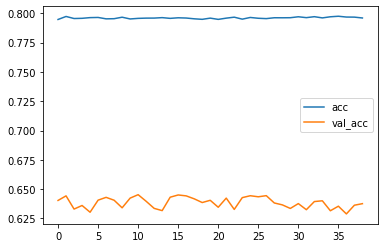

Epoch 40/100
5411/5411 [==============================] - 35s 6ms/step - loss: 0.4448 - acc: 0.7968 - val_loss: 0.7837 - val_acc: 0.6421

Epoch 00040: val_acc did not improve from 0.68460


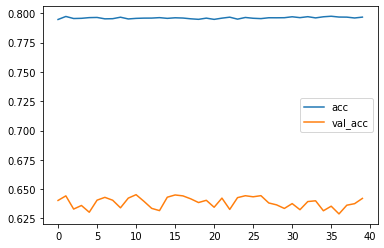

Epoch 41/100
5411/5411 [==============================] - 35s 6ms/step - loss: 0.4467 - acc: 0.7951 - val_loss: 0.7795 - val_acc: 0.6451

Epoch 00041: val_acc did not improve from 0.68460


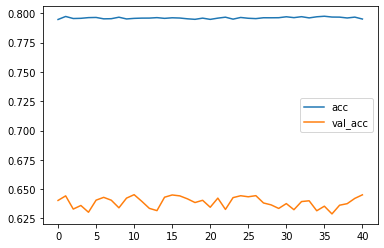

Epoch 42/100
5411/5411 [==============================] - 35s 6ms/step - loss: 0.4449 - acc: 0.7956 - val_loss: 0.8151 - val_acc: 0.6355

Epoch 00042: val_acc did not improve from 0.68460


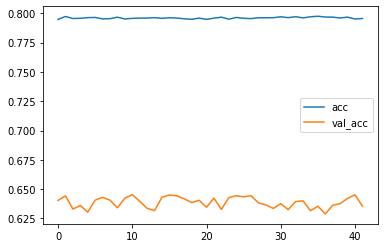

Epoch 43/100
5411/5411 [==============================] - 35s 7ms/step - loss: 0.4451 - acc: 0.7965 - val_loss: 0.7577 - val_acc: 0.6473

Epoch 00043: val_acc did not improve from 0.68460


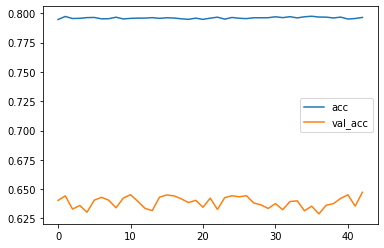

Epoch 44/100
5411/5411 [==============================] - 35s 6ms/step - loss: 0.4442 - acc: 0.7969 - val_loss: 0.8177 - val_acc: 0.6367

Epoch 00044: val_acc did not improve from 0.68460


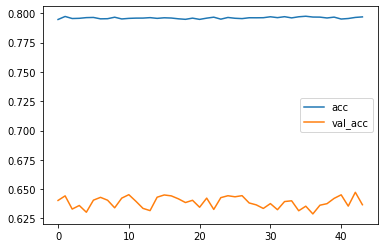

Epoch 45/100
5411/5411 [==============================] - 35s 7ms/step - loss: 0.4448 - acc: 0.7962 - val_loss: 0.8201 - val_acc: 0.6354

Epoch 00045: val_acc did not improve from 0.68460


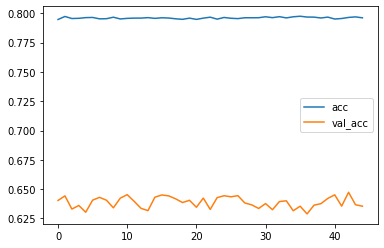

Epoch 46/100
5411/5411 [==============================] - 35s 7ms/step - loss: 0.4445 - acc: 0.7966 - val_loss: 0.7929 - val_acc: 0.6470

Epoch 00046: val_acc did not improve from 0.68460


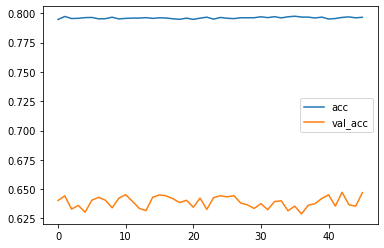

Epoch 47/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4443 - acc: 0.7971 - val_loss: 0.7972 - val_acc: 0.6390

Epoch 00047: val_acc did not improve from 0.68460


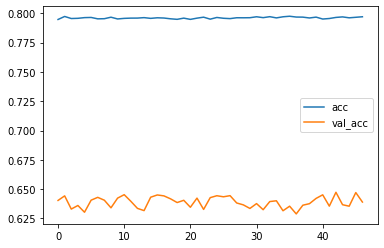

Epoch 48/100
5411/5411 [==============================] - 35s 7ms/step - loss: 0.4449 - acc: 0.7957 - val_loss: 0.7827 - val_acc: 0.6434

Epoch 00048: val_acc did not improve from 0.68460


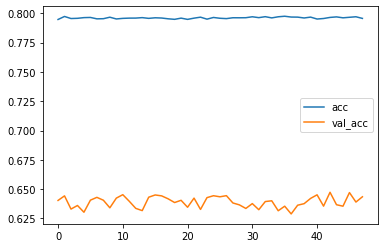

Epoch 49/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4434 - acc: 0.7978 - val_loss: 0.7793 - val_acc: 0.6412

Epoch 00049: val_acc did not improve from 0.68460


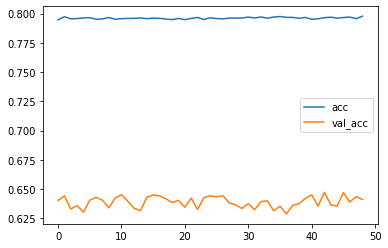

Epoch 50/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4454 - acc: 0.7960 - val_loss: 0.7922 - val_acc: 0.6368

Epoch 00050: val_acc did not improve from 0.68460


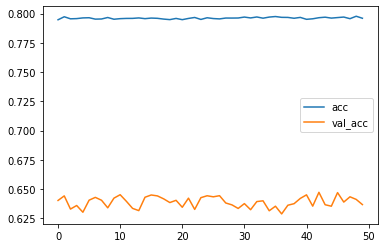

Epoch 51/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4466 - acc: 0.7962 - val_loss: 0.8002 - val_acc: 0.6400

Epoch 00051: val_acc did not improve from 0.68460


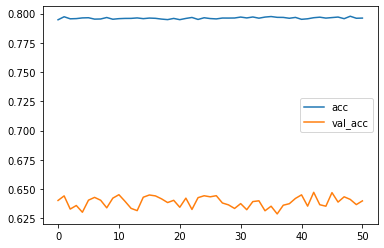

Epoch 52/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4444 - acc: 0.7962 - val_loss: 0.7884 - val_acc: 0.6403

Epoch 00052: val_acc did not improve from 0.68460


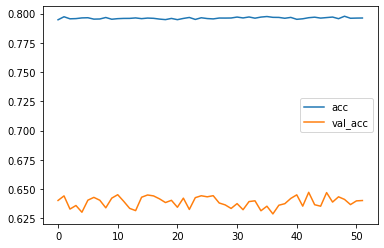

Epoch 53/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4453 - acc: 0.7959 - val_loss: 0.8026 - val_acc: 0.6434

Epoch 00053: val_acc did not improve from 0.68460


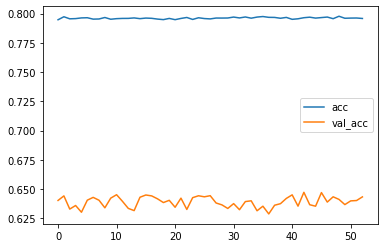

Epoch 54/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4441 - acc: 0.7971 - val_loss: 0.7988 - val_acc: 0.6348

Epoch 00054: val_acc did not improve from 0.68460


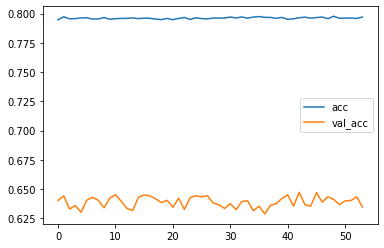

Epoch 55/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4446 - acc: 0.7963 - val_loss: 0.8131 - val_acc: 0.6397

Epoch 00055: val_acc did not improve from 0.68460


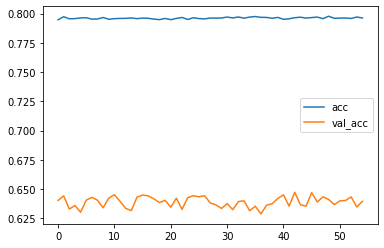

Epoch 56/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4453 - acc: 0.7962 - val_loss: 0.7807 - val_acc: 0.6397

Epoch 00056: val_acc did not improve from 0.68460


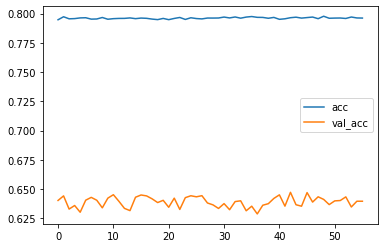

Epoch 57/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4442 - acc: 0.7962 - val_loss: 0.7935 - val_acc: 0.6336

Epoch 00057: val_acc did not improve from 0.68460


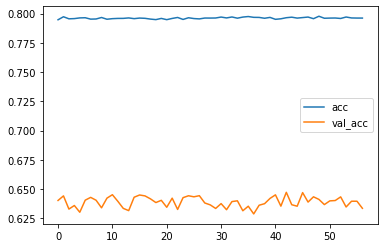

Epoch 58/100
5411/5411 [==============================] - 36s 7ms/step - loss: 0.4430 - acc: 0.7972 - val_loss: 0.7798 - val_acc: 0.6442

Epoch 00058: val_acc did not improve from 0.68460


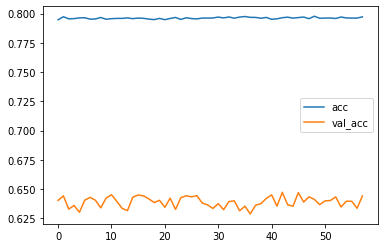

Epoch 59/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4440 - acc: 0.7969 - val_loss: 0.7985 - val_acc: 0.6402

Epoch 00059: val_acc did not improve from 0.68460


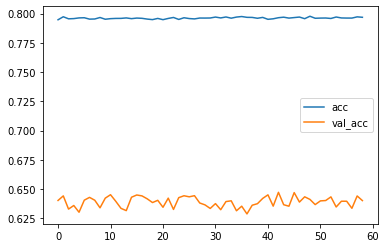

Epoch 60/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4435 - acc: 0.7976 - val_loss: 0.7973 - val_acc: 0.6390

Epoch 00060: val_acc did not improve from 0.68460


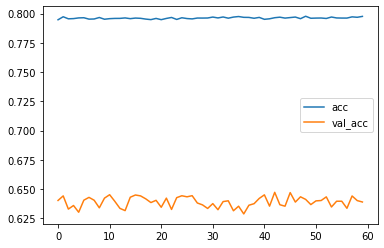

Epoch 61/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4453 - acc: 0.7961 - val_loss: 0.7666 - val_acc: 0.6451

Epoch 00061: val_acc did not improve from 0.68460


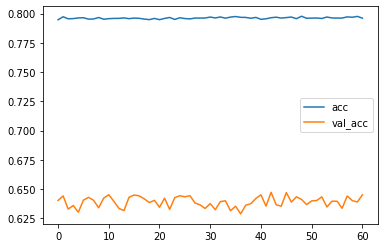

Epoch 62/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4440 - acc: 0.7963 - val_loss: 0.7859 - val_acc: 0.6423

Epoch 00062: val_acc did not improve from 0.68460


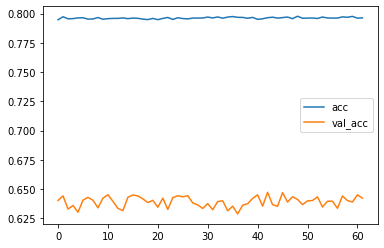

Epoch 63/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4436 - acc: 0.7966 - val_loss: 0.8002 - val_acc: 0.6319

Epoch 00063: val_acc did not improve from 0.68460


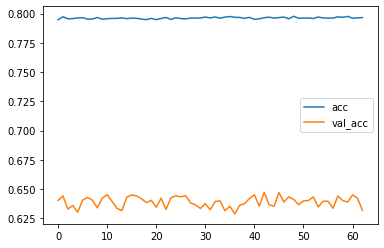

Epoch 64/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4447 - acc: 0.7960 - val_loss: 0.8080 - val_acc: 0.6314

Epoch 00064: val_acc did not improve from 0.68460


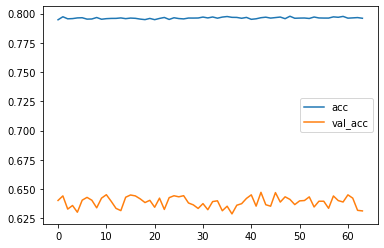

Epoch 65/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4438 - acc: 0.7965 - val_loss: 0.8142 - val_acc: 0.6364

Epoch 00065: val_acc did not improve from 0.68460


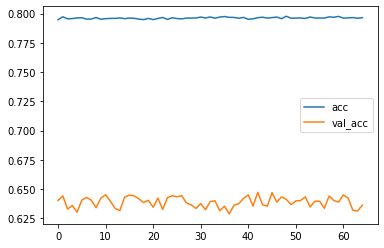

Epoch 66/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4443 - acc: 0.7964 - val_loss: 0.7793 - val_acc: 0.6346

Epoch 00066: val_acc did not improve from 0.68460


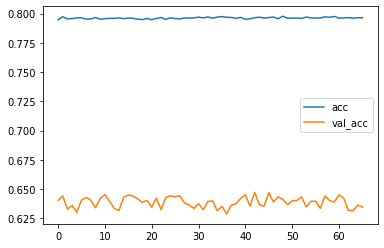

Epoch 67/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4447 - acc: 0.7961 - val_loss: 0.8253 - val_acc: 0.6295

Epoch 00067: val_acc did not improve from 0.68460


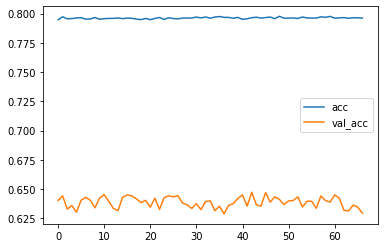

Epoch 68/100
5411/5411 [==============================] - 37s 7ms/step - loss: 0.4437 - acc: 0.7969 - val_loss: 0.7994 - val_acc: 0.6323

Epoch 00068: val_acc did not improve from 0.68460


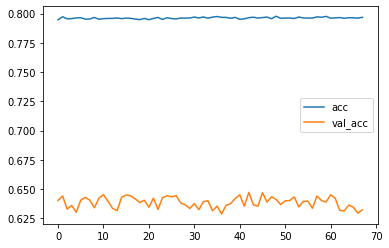

Epoch 69/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4448 - acc: 0.7964 - val_loss: 0.7773 - val_acc: 0.6407

Epoch 00069: val_acc did not improve from 0.68460


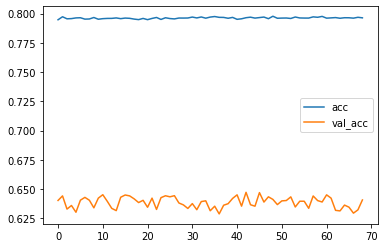

Epoch 70/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4430 - acc: 0.7971 - val_loss: 0.7963 - val_acc: 0.6445

Epoch 00070: val_acc did not improve from 0.68460


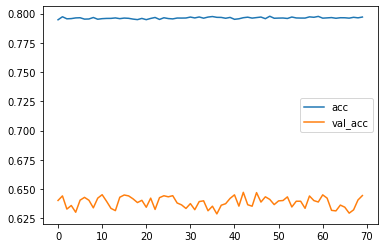

Epoch 71/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4462 - acc: 0.7951 - val_loss: 0.7902 - val_acc: 0.6369

Epoch 00071: val_acc did not improve from 0.68460


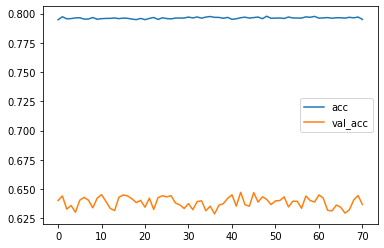

Epoch 72/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4438 - acc: 0.7969 - val_loss: 0.7992 - val_acc: 0.6372

Epoch 00072: val_acc did not improve from 0.68460


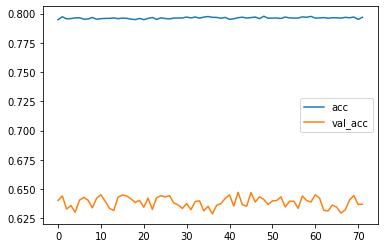

Epoch 73/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4424 - acc: 0.7975 - val_loss: 0.7804 - val_acc: 0.6335

Epoch 00073: val_acc did not improve from 0.68460


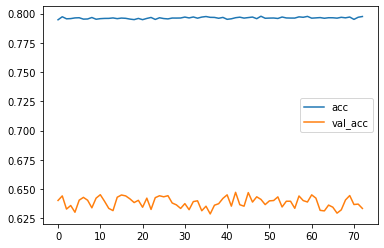

Epoch 74/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4434 - acc: 0.7969 - val_loss: 0.8150 - val_acc: 0.6342

Epoch 00074: val_acc did not improve from 0.68460


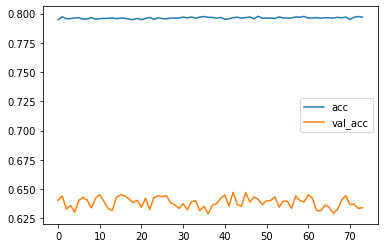

Epoch 75/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4437 - acc: 0.7969 - val_loss: 0.8115 - val_acc: 0.6349

Epoch 00075: val_acc did not improve from 0.68460


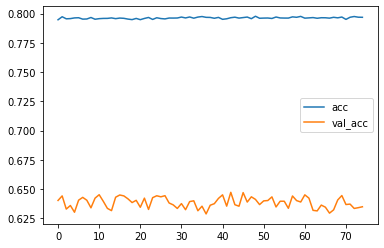

Epoch 76/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4440 - acc: 0.7972 - val_loss: 0.7982 - val_acc: 0.6304

Epoch 00076: val_acc did not improve from 0.68460


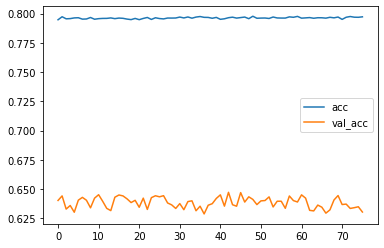

Epoch 77/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4436 - acc: 0.7973 - val_loss: 0.8123 - val_acc: 0.6326

Epoch 00077: val_acc did not improve from 0.68460


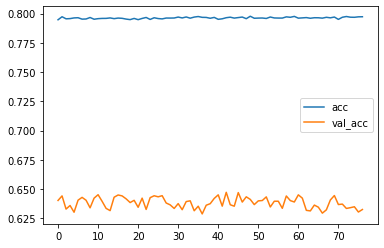

Epoch 78/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4434 - acc: 0.7977 - val_loss: 0.8038 - val_acc: 0.6400

Epoch 00078: val_acc did not improve from 0.68460


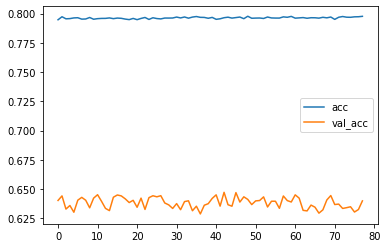

Epoch 79/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4432 - acc: 0.7966 - val_loss: 0.8224 - val_acc: 0.6406

Epoch 00079: val_acc did not improve from 0.68460


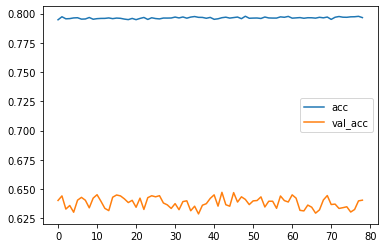

Epoch 80/100
5411/5411 [==============================] - 38s 7ms/step - loss: 0.4440 - acc: 0.7969 - val_loss: 0.7905 - val_acc: 0.6472

Epoch 00080: val_acc did not improve from 0.68460


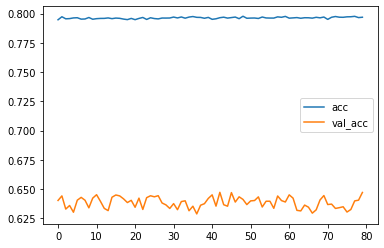

Epoch 81/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4435 - acc: 0.7966 - val_loss: 0.8238 - val_acc: 0.6360

Epoch 00081: val_acc did not improve from 0.68460


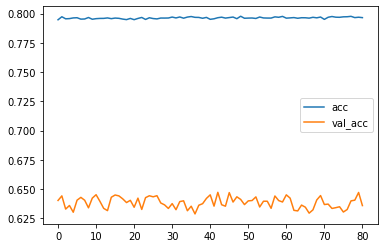

Epoch 82/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4441 - acc: 0.7961 - val_loss: 0.8035 - val_acc: 0.6367

Epoch 00082: val_acc did not improve from 0.68460


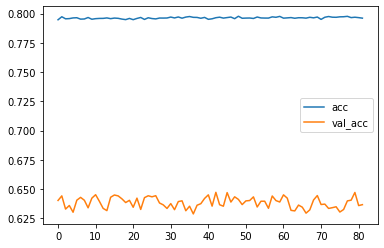

Epoch 83/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4433 - acc: 0.7974 - val_loss: 0.8042 - val_acc: 0.6382

Epoch 00083: val_acc did not improve from 0.68460


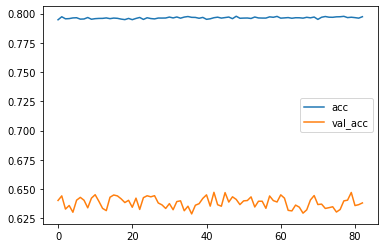

Epoch 84/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4431 - acc: 0.7961 - val_loss: 0.8085 - val_acc: 0.6339

Epoch 00084: val_acc did not improve from 0.68460


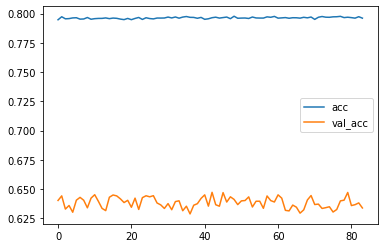

Epoch 85/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4428 - acc: 0.7974 - val_loss: 0.8092 - val_acc: 0.6348

Epoch 00085: val_acc did not improve from 0.68460


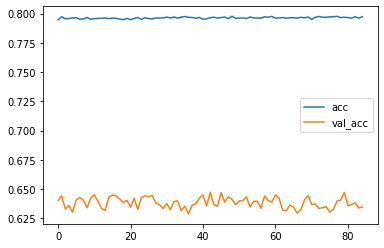

Epoch 86/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4441 - acc: 0.7970 - val_loss: 0.8240 - val_acc: 0.6305

Epoch 00086: val_acc did not improve from 0.68460


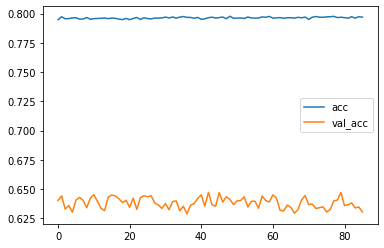

Epoch 87/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4426 - acc: 0.7975 - val_loss: 0.8152 - val_acc: 0.6356

Epoch 00087: val_acc did not improve from 0.68460


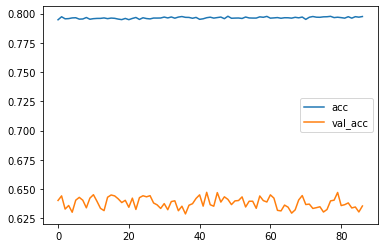

Epoch 88/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4427 - acc: 0.7980 - val_loss: 0.7886 - val_acc: 0.6387

Epoch 00088: val_acc did not improve from 0.68460


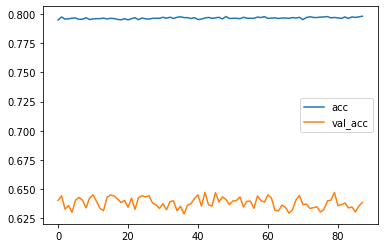

Epoch 89/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4418 - acc: 0.7989 - val_loss: 0.7945 - val_acc: 0.6460

Epoch 00089: val_acc did not improve from 0.68460


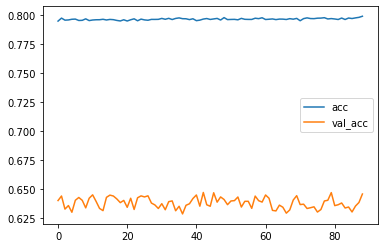

Epoch 90/100
5411/5411 [==============================] - 39s 7ms/step - loss: 0.4422 - acc: 0.7971 - val_loss: 0.8169 - val_acc: 0.6280

Epoch 00090: val_acc did not improve from 0.68460


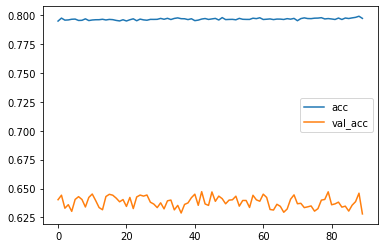

Epoch 91/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4424 - acc: 0.7973 - val_loss: 0.8355 - val_acc: 0.6351

Epoch 00091: val_acc did not improve from 0.68460


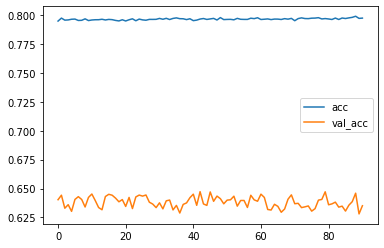

Epoch 92/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4447 - acc: 0.7960 - val_loss: 0.7847 - val_acc: 0.6410

Epoch 00092: val_acc did not improve from 0.68460


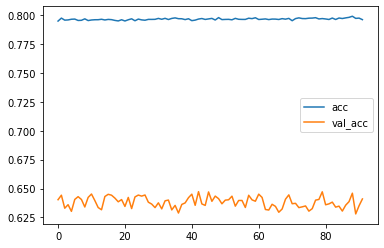

Epoch 93/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4424 - acc: 0.7983 - val_loss: 0.7970 - val_acc: 0.6406

Epoch 00093: val_acc did not improve from 0.68460


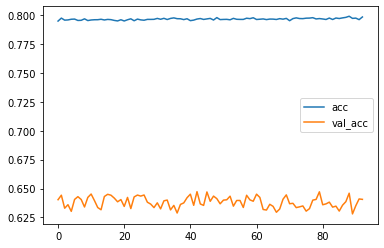

Epoch 94/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4432 - acc: 0.7968 - val_loss: 0.8241 - val_acc: 0.6294

Epoch 00094: val_acc did not improve from 0.68460


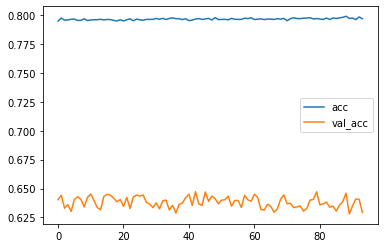

Epoch 95/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4437 - acc: 0.7969 - val_loss: 0.8112 - val_acc: 0.6275

Epoch 00095: val_acc did not improve from 0.68460


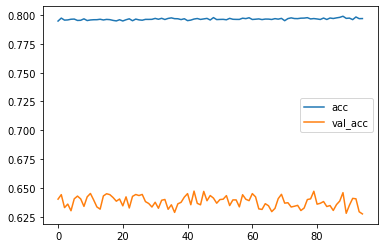

Epoch 96/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4421 - acc: 0.7975 - val_loss: 0.8457 - val_acc: 0.6311

Epoch 00096: val_acc did not improve from 0.68460


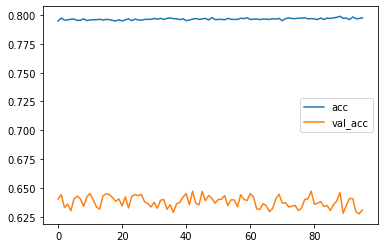

Epoch 97/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4439 - acc: 0.7971 - val_loss: 0.7871 - val_acc: 0.6359

Epoch 00097: val_acc did not improve from 0.68460


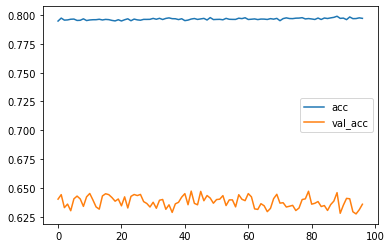

Epoch 98/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4425 - acc: 0.7976 - val_loss: 0.8144 - val_acc: 0.6352

Epoch 00098: val_acc did not improve from 0.68460


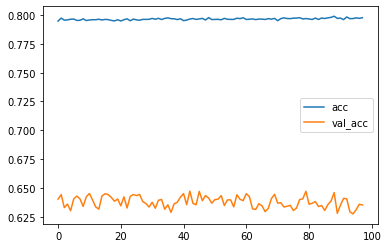

Epoch 99/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4422 - acc: 0.7988 - val_loss: 0.7881 - val_acc: 0.6410

Epoch 00099: val_acc did not improve from 0.68460


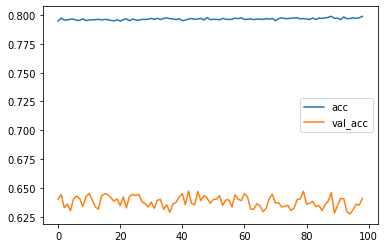

Epoch 100/100
5411/5411 [==============================] - 40s 7ms/step - loss: 0.4437 - acc: 0.7968 - val_loss: 0.7948 - val_acc: 0.6403

Epoch 00100: val_acc did not improve from 0.68460


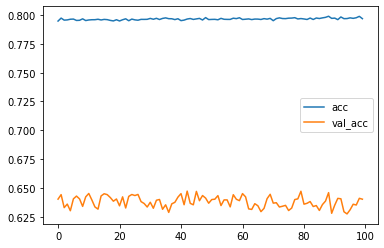

In [ ]:
# #Train Model
# h = model.fit(
#     x_train,
#     y_train,
#     epochs=100,
#     validation_data=(x_val,y_val),
#     callbacks=[checkpoint,plot_losses])
# model.save('drive/MyDrive/Dataset/model/model_LSTM_noga_400ep.h5')

In [ ]:
# model = load_model('drive/MyDrive/Dataset/model/model_LSTM_notrading.h5')

Confusion Matrix
[[1706  470]
 [ 657  202]]
Accuracy
0.628665568369028
Confusion Matrix
[[1064  288]
 [ 718  383]]
Accuracy
0.5898899306971056
Confusion Matrix
[[965 539]
 [555 433]]
Accuracy
0.5609951845906902
Confusion Matrix
[[1449  459]
 [ 680  237]]
Accuracy
0.5968141592920354


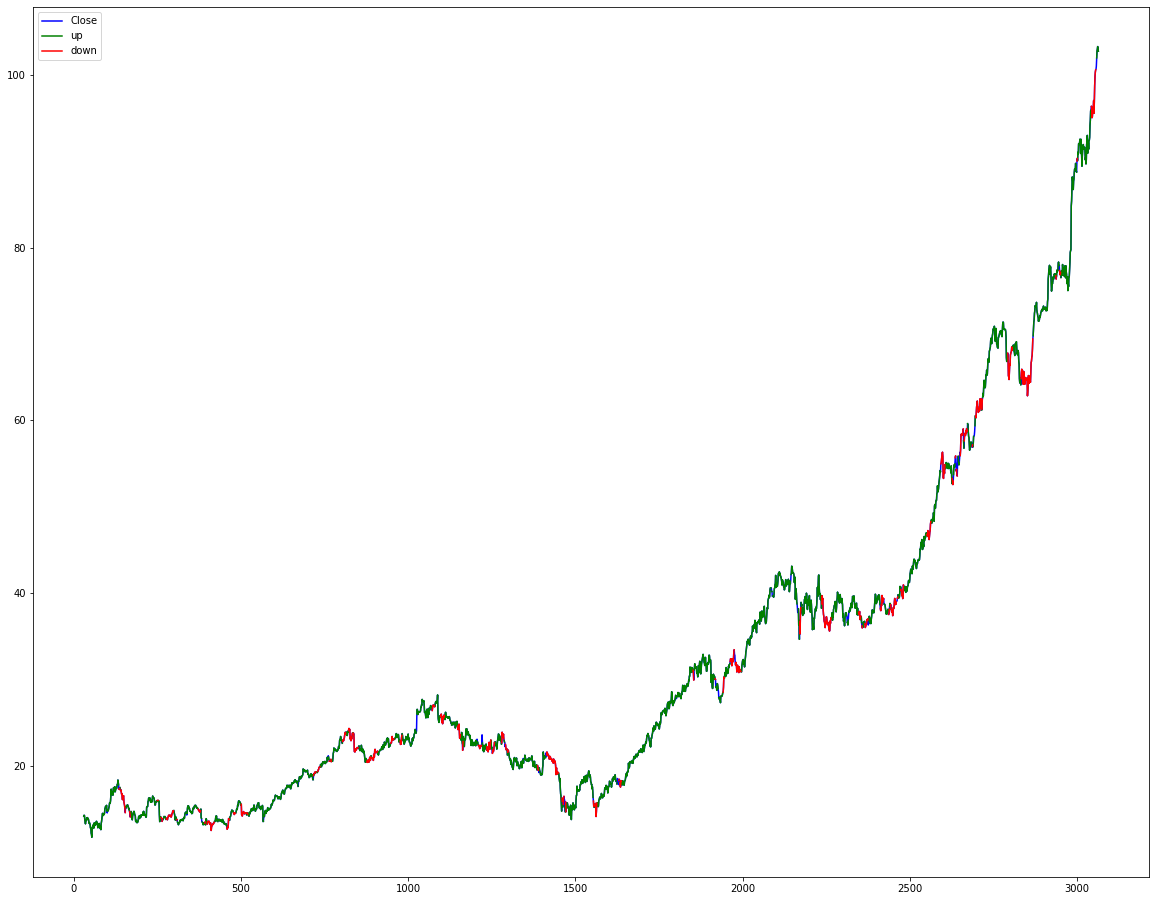

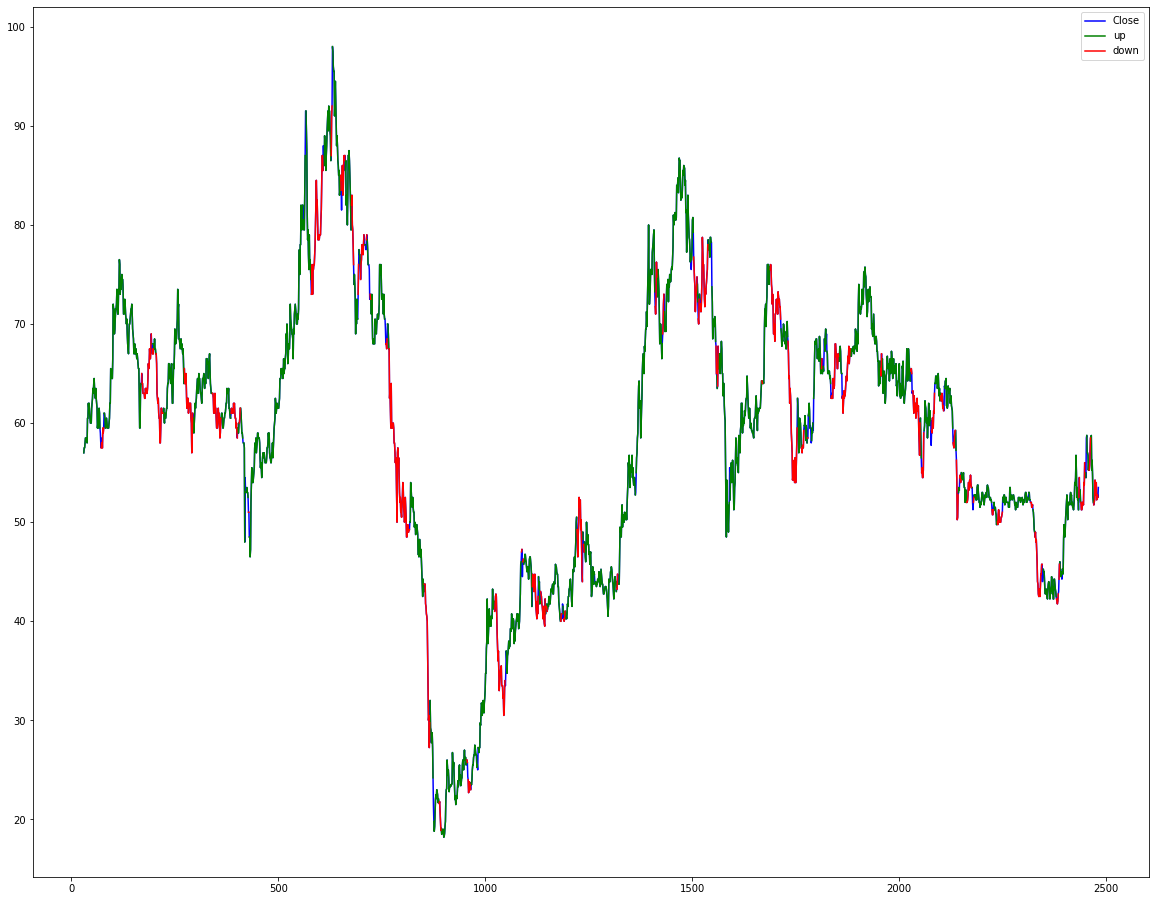

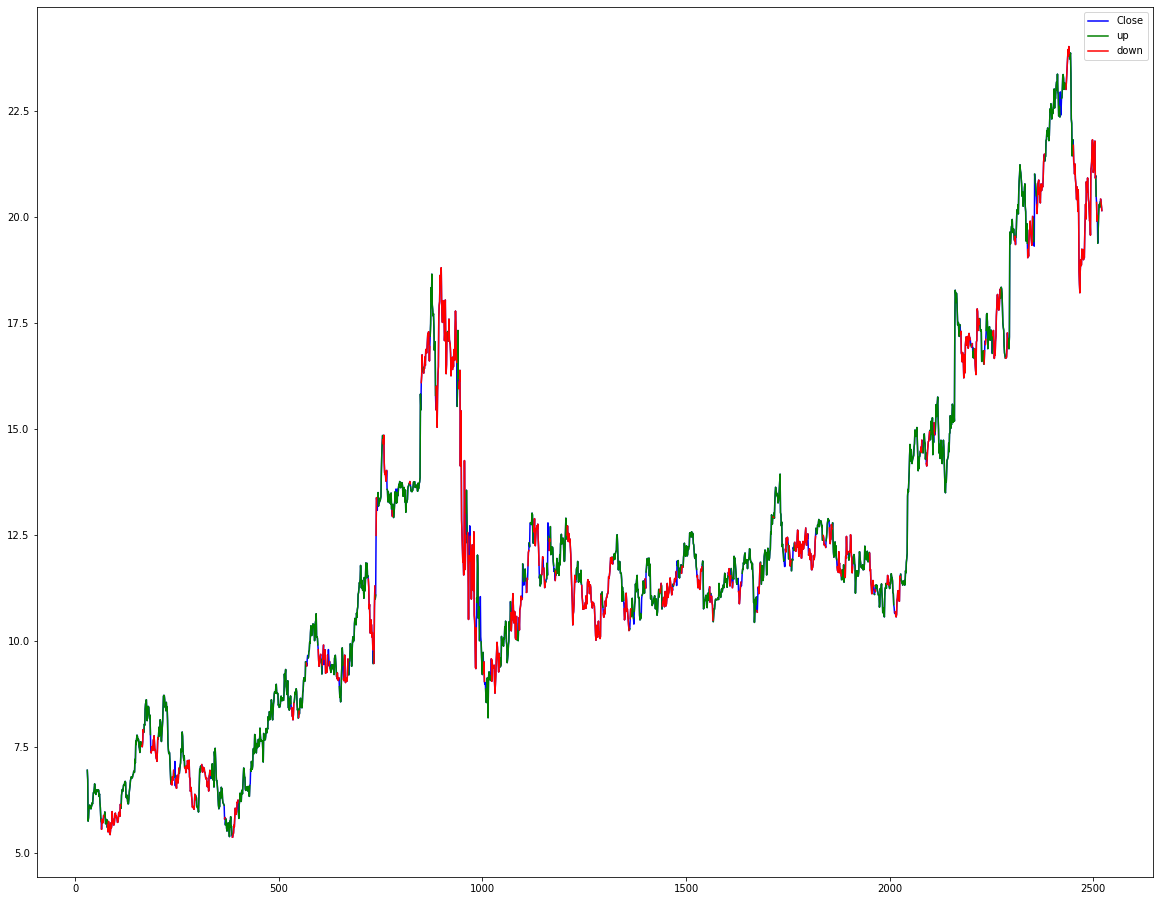

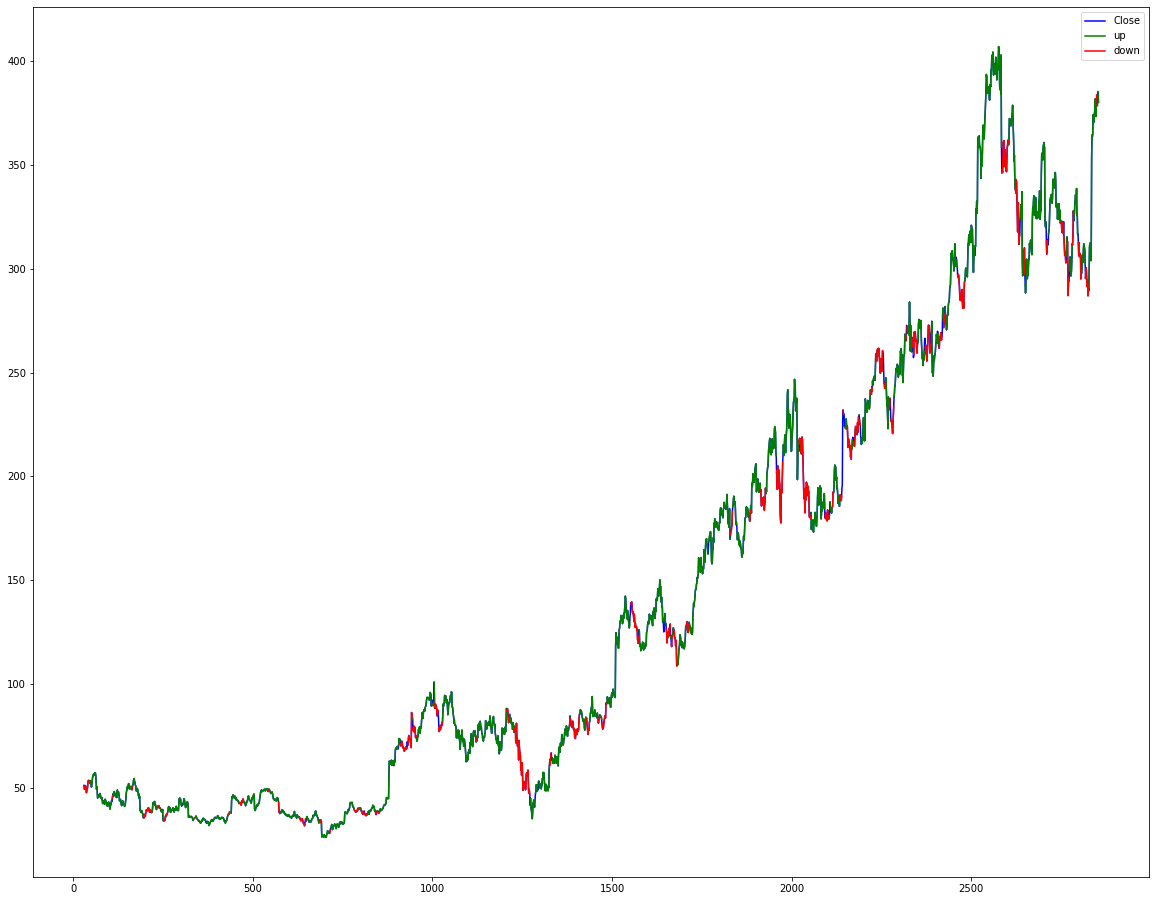

In [ ]:
#test set
for val_name in range(71,75):
    df = pd.read_csv(datalist[val_name])
    df = signal_to_catagorical(df)
    df = df.dropna()
    x_test = df[['MACD-SL_n','DMI_n','STOCH_n','RSI_n','%R_n']].values
    y_test = df['Trend GT'].values
    x_test = add_shift_day(x_test,30)
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis = -1)
    y_test = y_test.astype('int64')
    y_test = y_test[30:]
    cm = confusion_matrix(y_test, y_pred)
    ac = accuracy_score(y_test,y_pred)
    print("Confusion Matrix")
    print(cm)
    print("Accuracy")
    print(ac)
    df = df[30:]
    df['up'] = np.where(y_pred==0,df['Close'],np.nan)
    df['down'] = np.where(y_pred==1,df['Close'],np.nan)
    df[['Close','up','down']].plot(figsize=(20,16),color=['blue','green','red']).get_figure().savefig('Predict.png')

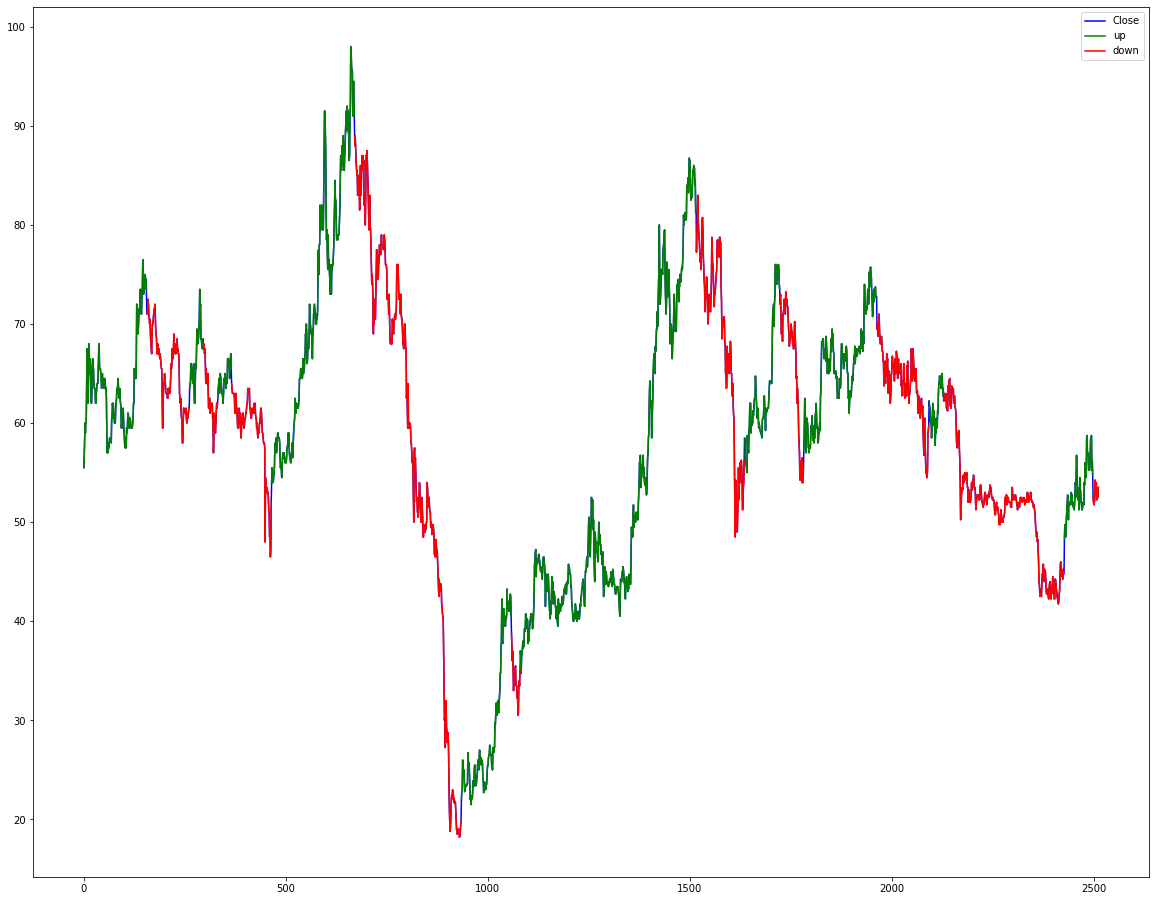

In [ ]:
df = pd.read_csv(datalist[71])
df['up'] = np.where(df['Trend GT']=='up',df['Close'],np.nan)
df['down'] = np.where(df['Trend GT']=='down',df['Close'],np.nan)
df[['Close','up','down']].plot(figsize=(20,16),color=['blue','green','red']).get_figure().savefig('GT.png')